In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from functools import total_ordering

Dataloader (MNIST, FASHION MNIST, SIMPLE SHAPES)

Loaded into dictionaries of those names

In [ ]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
from skimage.draw import polygon

def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    return dataset.data.float().view(-1, 784) / 255.0, dataset.targets

def load_fashion_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return dataset.data.float().view(-1, 784) / 255.0, dataset.targets

def create_simple_shapes(num_samples=60000, image_size=28):
    shapes = []
    labels = []
    for _ in range(num_samples):
        img = np.zeros((image_size, image_size), dtype=np.float32)
        shape_type = np.random.choice(['circle', 'square', 'triangle'])
        label = 0 if shape_type == 'circle' else 1 if shape_type == 'square' else 2

        if shape_type == 'circle':
            center = (np.random.randint(image_size//4, 3*image_size//4),
                      np.random.randint(image_size//4, 3*image_size//4))
            radius = np.random.randint(image_size//8, image_size//4)
            y, x = np.ogrid[:image_size, :image_size]
            dist_from_center = np.sqrt((x - center[0])**2 + (y-center[1])**2)
            img[dist_from_center <= radius] = 1

        elif shape_type == 'square':
            top_left = (np.random.randint(0, image_size//2), np.random.randint(0, image_size//2))
            size = np.random.randint(image_size//4, image_size//2)
            img[top_left[0]:top_left[0]+size, top_left[1]:top_left[1]+size] = 1

        else:  # triangle
            points = np.random.randint(0, image_size, size=(3, 2))
            rr, cc = polygon(points[:, 0], points[:, 1], img.shape)
            img[rr, cc] = 1

        shapes.append(img.reshape(-1))
        labels.append(label)

    return torch.tensor(shapes), torch.tensor(labels)

# Load datasets - labels aren't used, but nice to have handy
mnist_data, mnist_labels = load_mnist()
fashion_mnist_data, fashion_mnist_labels = load_fashion_mnist()
simple_shapes_data, simple_shapes_labels = create_simple_shapes()

datasets = {
    "MNIST": (mnist_data, mnist_labels),
    "Fashion-MNIST": (fashion_mnist_data, fashion_mnist_labels),
    "Simple Shapes": (simple_shapes_data, simple_shapes_labels)
}

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 931610.94it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134467.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:04<00:00, 362746.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3854821.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26421880/26421880 [00:21<00:00, 1210086.29it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 168718.79it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 573566.68it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23019485.07it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



<ipython-input-2-33c8b295fabb>:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(shapes), torch.tensor(labels)


Various plotting and visualisation methods used later:

In [ ]:
#Code for visualising samples and analysing codebook

def visualize_tensor_grid(tensor, captions):
  # Assuming tensor shape is [2, 10, 784]
  num_rows = tensor.shape[0]
  num_cols = tensor.shape[1]

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))

  for i in range(num_rows):
    for j in range(num_cols):
      image = tensor[i, j].reshape(28, 28)  # Reshape to 28x28
      axes[i, j].imshow(image, cmap='gray')
      axes[i, j].axis('off')
      # Set title for each subplot individually
      if i ==0:
        axes[i,j].set_title(f"Score: {captions[j].item():.4f}") # captions is a 2D array, so we need to index it properly

  plt.tight_layout()
  plt.show()


def visualize_samples(data, num_samples=10):
    # Reshape the data to image dimensions (assuming MNIST-like data)
    image_size = int(np.sqrt(data.shape[1]))
    data = data.view(data.shape[0], 1, image_size, image_size)

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

    # Display the images
    for i in range(num_samples):
        axes[i].imshow(data[i, 0].detach().numpy(), cmap='gray')
        axes[i].axis('off')

    plt.show()

def analyze_codebook_most_used(model, input_data, num_samples=1000, dataset_name=""):
    print("Analysing Codebook:")
    model.eval()
    with torch.no_grad():
        # Sample random inputs
        indices = torch.randint(0, len(input_data), (num_samples,))
        samples = input_data[indices]

        # Encode samples
        encoded = model.encoder(samples)
        quantized, _, _, encodings = model.vq(encoded)

        # Get most used codes
        code_usage = encodings.sum(dim=0)
        top_codes = torch.argsort(code_usage, descending=True)[:20]  # Top 20 most used codes

        # Visualize top codes
        fig, axes = plt.subplots(4, 5, figsize=(10, 6))
        fig.suptitle(f"{dataset_name} - Top 20 Most Used Codes")
        for i, code in enumerate(top_codes):
            code_vector = model.vq.embedding.weight[code].view(1, -1)
            reconstruction = model.decoder(code_vector).view(28, 28)
            ax = axes[i // 5, i % 5]
            ax.imshow(reconstruction.cpu().numpy(), cmap='gray')
            ax.axis('off')
            ax.set_title(f"Code {code.item()}")
        plt.tight_layout()
        plt.show()

def print_codebook(model):
    print("Analysing Codebook:")
    model.eval()
    with torch.no_grad():


        codes = model.vq.get_codebook()

        # Visualize top codes
        fig, axes = plt.subplots(4, 5, figsize=(10, 6))

        for i, code in enumerate(codes):
            code_vector = codes.view(1, -1)
            ax = axes[i // 5, i % 5]
            ax.imshow(code.cpu().numpy(), cmap='gray')
            ax.axis('off')
            ax.set_title(f"Code {code.item()}")
        plt.tight_layout()
        plt.show()

def print_trainable_codebook(model):
    print("Analysing Trainable Codebook:")
    model.eval()
    with torch.no_grad():


        codes = model.vq.get_trainable_codebook()

        for code in codes:
          print(code)
'''
        # Visualize top codes
        fig, axes = plt.subplots(4, 5, figsize=(10, 6))

        for i, code in enumerate(codes):
            code_vector = codes.view(1, -1)
            ax = axes[i // 5, i % 5]
            ax.imshow(code.cpu().numpy(), cmap='gray')
            ax.axis('off')
            ax.set_title(f"Code {code.item()}")
        plt.tight_layout()
        plt.show()
'''

def visualize_codebook_decodings(descriptor_model, decoder_model, image_shape=(28, 28), num_cols=8):
    # Ensure the models are in evaluation mode
    descriptor_model.eval()
    decoder_model.eval()

    codebook = descriptor_model.get_codebook()

    # Get the number of codes in the codebook
    num_codes = codebook.shape[0]

    # Calculate the number of rows needed
    num_rows = (num_codes + num_cols - 1) // num_cols

    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))
    axes = axes.flatten()

    with torch.no_grad():
        for i, code in enumerate(codebook):
            # Reshape the code to match the decoder's input shape
            code_input = code.unsqueeze(0)  # Add batch dimension

            # Decode the code
            decoded = decoder_model(code_input)

            # Reshape the decoded output to image shape
            decoded_image = decoded.squeeze().cpu().numpy().reshape(image_shape)

            # Plot the decoded image
            axes[i].imshow(decoded_image, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Code {i+1}')

    # Remove any unused subplots
    for j in range(num_codes, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_codes_as_image(codebook, num_cols=8):
    """Plots the codebook entries as images."""
    num_codes = codebook.shape[0]
    #num_rows = (num_codes + num_cols - 1) // num_cols
    #fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))

    for i, code in enumerate(codebook):
        print(code)


Component Modules for Neural Nets:

Vector Quantizer implements VQVAE-style quantisation

Descriptor encodes and quantises an input image

Discriminator takes a quantized representation and an image in image space and outputs a single score in the interval [0,1]

Decoder projects a quantised representation back into image space as in the second half of a VQVAE

In [ ]:
#Vector Quantizer module as per VQVAE architecture

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def get_codebook(self):
        return self.embedding.weight.data

    def forward(self, inputs):

        if inputs.dim() == 1:
              inputs = inputs.unsqueeze(0)

        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self.embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize
        quantized = torch.matmul(encodings, self.embedding.weight)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, loss, perplexity, encodings

In [ ]:
class Descriptor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_embeddings, embedding_dim):
        super(Descriptor, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

        # Vector Quantizer
        self.vq = VectorQuantizer(num_embeddings, embedding_dim)

    def get_codebook(self):
        return self.vq.get_codebook()

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, perplexity, _ = self.vq(z)

        return z, quantized, vq_loss, perplexity

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # Use Sigmoid for MNIST as pixel values are between 0 and 1
        )

    def forward(self, x):
        return self.decoder(x)

In [ ]:
#Discriminator is a moderate modification to the VQVAE decoder
#

class Discriminator(nn.Module):
    def __init__(self, input_image_dim, embedding_dim, hidden_dim):
        super().__init__()


        self.vq_decoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU()
            #nn.Linear(hidden_dim, input_image_dim),
            #nn.Sigmoid()  # Added to ensure output is in [0, 1] range
        )

        self.image_encoder = nn.Sequential(
            nn.Linear(input_image_dim, hidden_dim),
            nn.ReLU())
            #nn.Linear(hidden_dim, embedding_dim))

        self.matching_layer = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, vq_input, image_input):
        vq_decoding = self.vq_decoder(vq_input)
        image_encoding = self.image_encoder(image_input)
        combined_encoding = torch.cat([vq_decoding, image_encoding], dim=1)
        output = self.matching_layer(combined_encoding)
        return output

A Basic descriptor-decoder configuration ie a standard VQVAE to test modules
(string diagram to be inserted)

VQVAE trained and each code in the codebook is decoded and displayed every 10 epochs

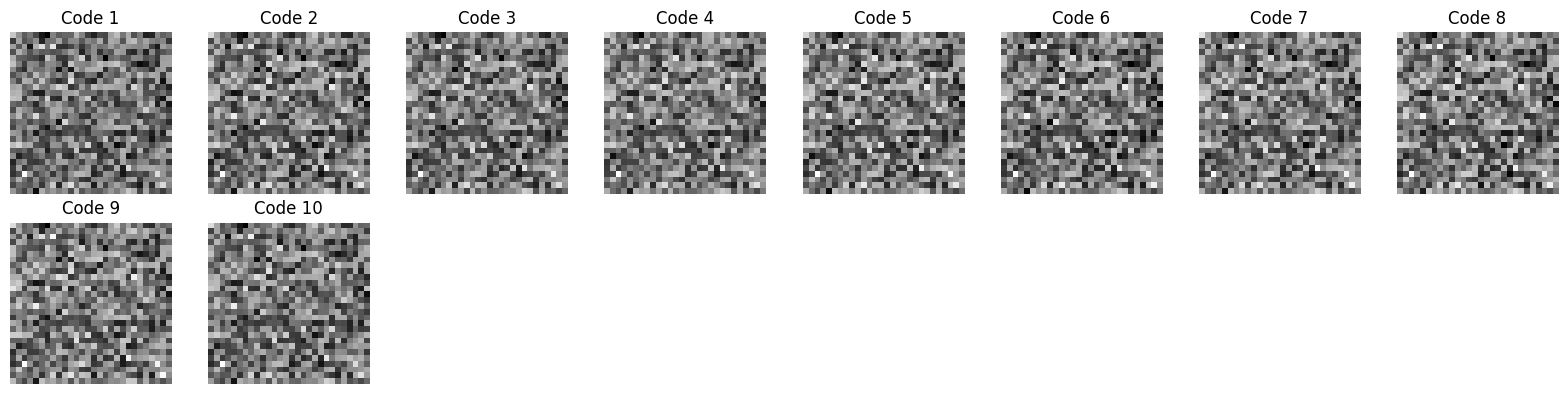

Epoch [1/100], Total Loss: 0.0934, Rec Loss: 0.0668, VQ Loss: 0.0266
Epoch [2/100], Total Loss: 0.0679, Rec Loss: 0.0638, VQ Loss: 0.0041
Epoch [3/100], Total Loss: 0.0662, Rec Loss: 0.0631, VQ Loss: 0.0031
Epoch [4/100], Total Loss: 0.0690, Rec Loss: 0.0630, VQ Loss: 0.0060
Epoch [5/100], Total Loss: 0.0701, Rec Loss: 0.0631, VQ Loss: 0.0070
Epoch [6/100], Total Loss: 0.0658, Rec Loss: 0.0621, VQ Loss: 0.0037
Epoch [7/100], Total Loss: 0.0647, Rec Loss: 0.0611, VQ Loss: 0.0036
Epoch [8/100], Total Loss: 0.0666, Rec Loss: 0.0608, VQ Loss: 0.0057
Epoch [9/100], Total Loss: 0.0655, Rec Loss: 0.0600, VQ Loss: 0.0054
Epoch [10/100], Total Loss: 0.0654, Rec Loss: 0.0593, VQ Loss: 0.0060


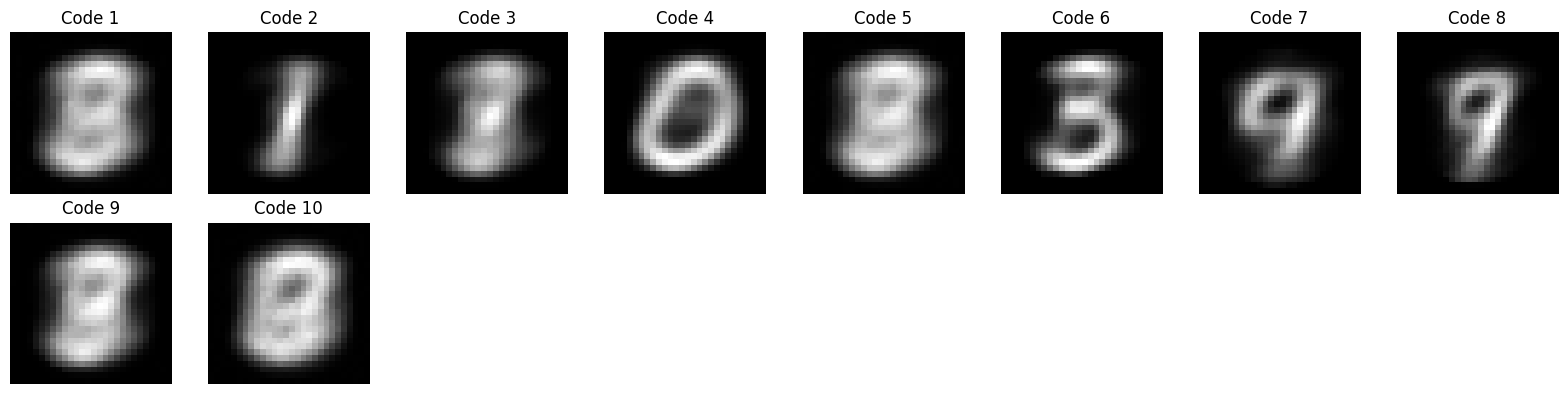

Epoch [11/100], Total Loss: 0.0665, Rec Loss: 0.0591, VQ Loss: 0.0073
Epoch [12/100], Total Loss: 0.0664, Rec Loss: 0.0585, VQ Loss: 0.0079
Epoch [13/100], Total Loss: 0.0667, Rec Loss: 0.0579, VQ Loss: 0.0089
Epoch [14/100], Total Loss: 0.0675, Rec Loss: 0.0573, VQ Loss: 0.0102
Epoch [15/100], Total Loss: 0.0688, Rec Loss: 0.0569, VQ Loss: 0.0119
Epoch [16/100], Total Loss: 0.0695, Rec Loss: 0.0564, VQ Loss: 0.0131
Epoch [17/100], Total Loss: 0.0706, Rec Loss: 0.0565, VQ Loss: 0.0141
Epoch [18/100], Total Loss: 0.0726, Rec Loss: 0.0574, VQ Loss: 0.0151
Epoch [19/100], Total Loss: 0.0736, Rec Loss: 0.0578, VQ Loss: 0.0158
Epoch [20/100], Total Loss: 0.0724, Rec Loss: 0.0565, VQ Loss: 0.0160


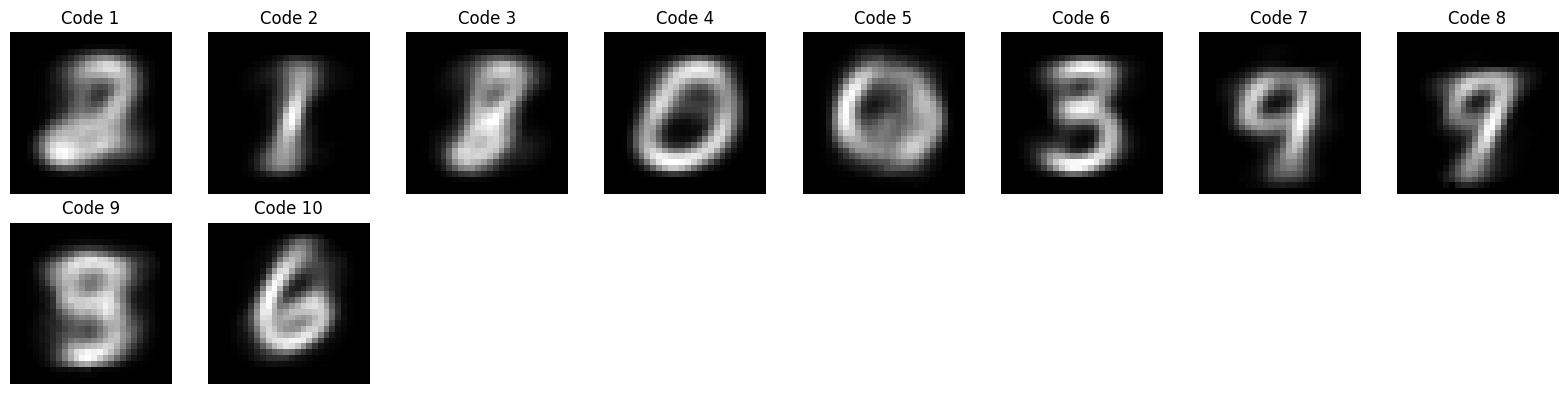

Epoch [21/100], Total Loss: 0.0733, Rec Loss: 0.0564, VQ Loss: 0.0169
Epoch [22/100], Total Loss: 0.0751, Rec Loss: 0.0571, VQ Loss: 0.0181
Epoch [23/100], Total Loss: 0.0749, Rec Loss: 0.0564, VQ Loss: 0.0185
Epoch [24/100], Total Loss: 0.0767, Rec Loss: 0.0569, VQ Loss: 0.0198
Epoch [25/100], Total Loss: 0.0765, Rec Loss: 0.0563, VQ Loss: 0.0203
Epoch [26/100], Total Loss: 0.0783, Rec Loss: 0.0574, VQ Loss: 0.0209
Epoch [27/100], Total Loss: 0.0779, Rec Loss: 0.0570, VQ Loss: 0.0209
Epoch [28/100], Total Loss: 0.0781, Rec Loss: 0.0568, VQ Loss: 0.0214
Epoch [29/100], Total Loss: 0.0786, Rec Loss: 0.0566, VQ Loss: 0.0220
Epoch [30/100], Total Loss: 0.0785, Rec Loss: 0.0569, VQ Loss: 0.0216


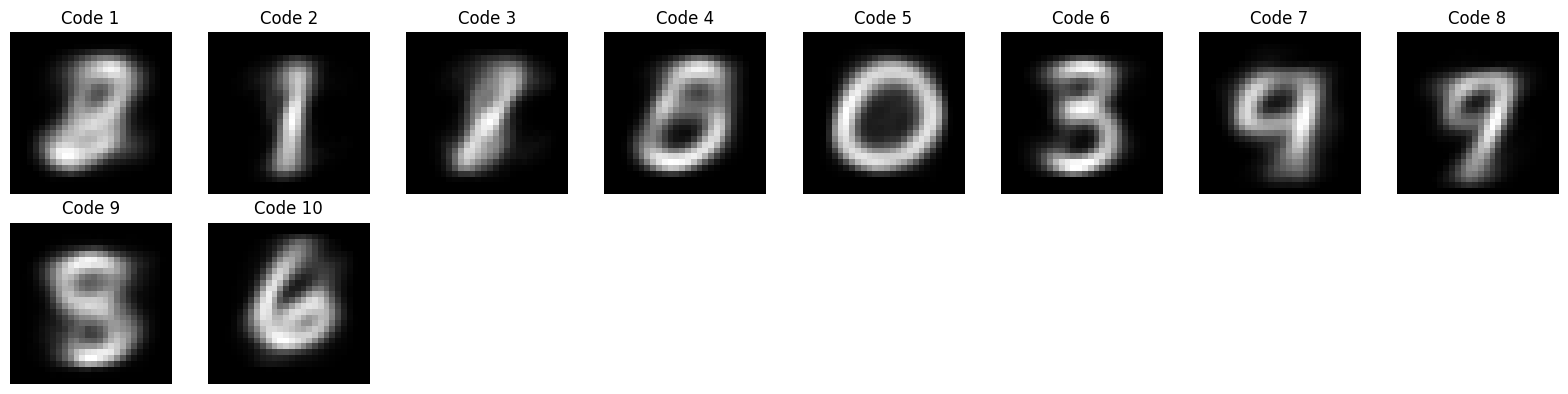

Epoch [31/100], Total Loss: 0.0781, Rec Loss: 0.0563, VQ Loss: 0.0218
Epoch [32/100], Total Loss: 0.0785, Rec Loss: 0.0568, VQ Loss: 0.0217
Epoch [33/100], Total Loss: 0.0790, Rec Loss: 0.0569, VQ Loss: 0.0221
Epoch [34/100], Total Loss: 0.0787, Rec Loss: 0.0571, VQ Loss: 0.0217
Epoch [35/100], Total Loss: 0.0788, Rec Loss: 0.0570, VQ Loss: 0.0218
Epoch [36/100], Total Loss: 0.0788, Rec Loss: 0.0570, VQ Loss: 0.0218
Epoch [37/100], Total Loss: 0.0789, Rec Loss: 0.0570, VQ Loss: 0.0218
Epoch [38/100], Total Loss: 0.0786, Rec Loss: 0.0570, VQ Loss: 0.0217
Epoch [39/100], Total Loss: 0.0782, Rec Loss: 0.0569, VQ Loss: 0.0213
Epoch [40/100], Total Loss: 0.0785, Rec Loss: 0.0569, VQ Loss: 0.0216


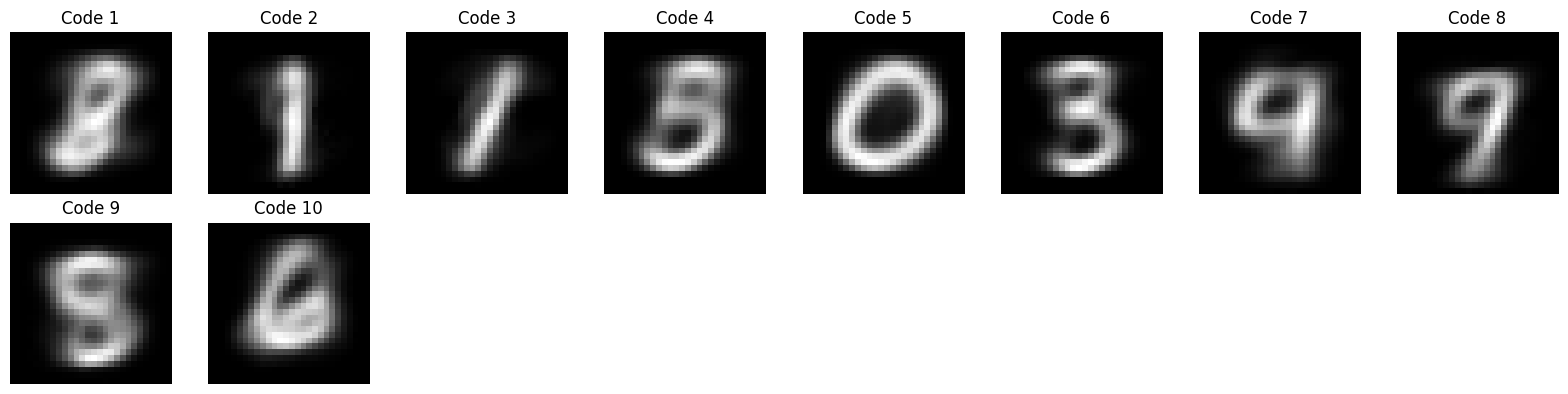

Epoch [41/100], Total Loss: 0.0780, Rec Loss: 0.0570, VQ Loss: 0.0210
Epoch [42/100], Total Loss: 0.0779, Rec Loss: 0.0570, VQ Loss: 0.0209
Epoch [43/100], Total Loss: 0.0778, Rec Loss: 0.0568, VQ Loss: 0.0210
Epoch [44/100], Total Loss: 0.0773, Rec Loss: 0.0567, VQ Loss: 0.0206
Epoch [45/100], Total Loss: 0.0775, Rec Loss: 0.0567, VQ Loss: 0.0208
Epoch [46/100], Total Loss: 0.0774, Rec Loss: 0.0567, VQ Loss: 0.0207
Epoch [47/100], Total Loss: 0.0774, Rec Loss: 0.0569, VQ Loss: 0.0205
Epoch [48/100], Total Loss: 0.0773, Rec Loss: 0.0569, VQ Loss: 0.0204
Epoch [49/100], Total Loss: 0.0767, Rec Loss: 0.0566, VQ Loss: 0.0201
Epoch [50/100], Total Loss: 0.0765, Rec Loss: 0.0566, VQ Loss: 0.0200


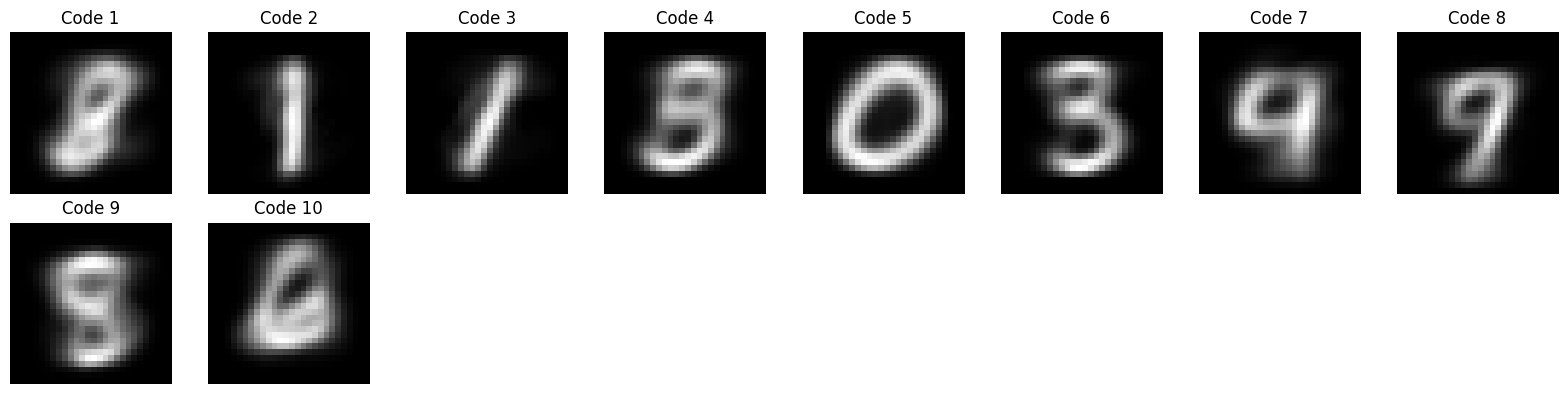

Epoch [51/100], Total Loss: 0.0765, Rec Loss: 0.0565, VQ Loss: 0.0200
Epoch [52/100], Total Loss: 0.0767, Rec Loss: 0.0567, VQ Loss: 0.0200
Epoch [53/100], Total Loss: 0.0760, Rec Loss: 0.0565, VQ Loss: 0.0195
Epoch [54/100], Total Loss: 0.0770, Rec Loss: 0.0567, VQ Loss: 0.0203
Epoch [55/100], Total Loss: 0.0765, Rec Loss: 0.0564, VQ Loss: 0.0201
Epoch [56/100], Total Loss: 0.0758, Rec Loss: 0.0560, VQ Loss: 0.0197
Epoch [57/100], Total Loss: 0.0748, Rec Loss: 0.0557, VQ Loss: 0.0191
Epoch [58/100], Total Loss: 0.0741, Rec Loss: 0.0553, VQ Loss: 0.0189
Epoch [59/100], Total Loss: 0.0736, Rec Loss: 0.0552, VQ Loss: 0.0184
Epoch [60/100], Total Loss: 0.0730, Rec Loss: 0.0554, VQ Loss: 0.0176


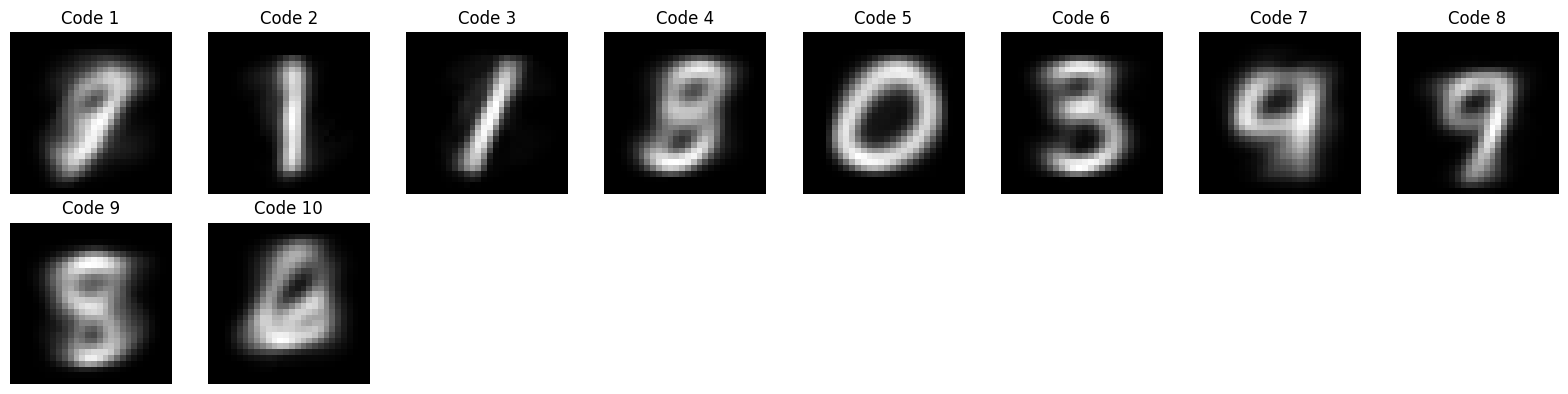

Epoch [61/100], Total Loss: 0.0720, Rec Loss: 0.0551, VQ Loss: 0.0169
Epoch [62/100], Total Loss: 0.0716, Rec Loss: 0.0550, VQ Loss: 0.0166
Epoch [63/100], Total Loss: 0.0711, Rec Loss: 0.0549, VQ Loss: 0.0162
Epoch [64/100], Total Loss: 0.0715, Rec Loss: 0.0550, VQ Loss: 0.0165
Epoch [65/100], Total Loss: 0.0715, Rec Loss: 0.0549, VQ Loss: 0.0165
Epoch [66/100], Total Loss: 0.0709, Rec Loss: 0.0550, VQ Loss: 0.0159
Epoch [67/100], Total Loss: 0.0712, Rec Loss: 0.0549, VQ Loss: 0.0163
Epoch [68/100], Total Loss: 0.0708, Rec Loss: 0.0550, VQ Loss: 0.0158
Epoch [69/100], Total Loss: 0.0709, Rec Loss: 0.0551, VQ Loss: 0.0159
Epoch [70/100], Total Loss: 0.0714, Rec Loss: 0.0553, VQ Loss: 0.0161


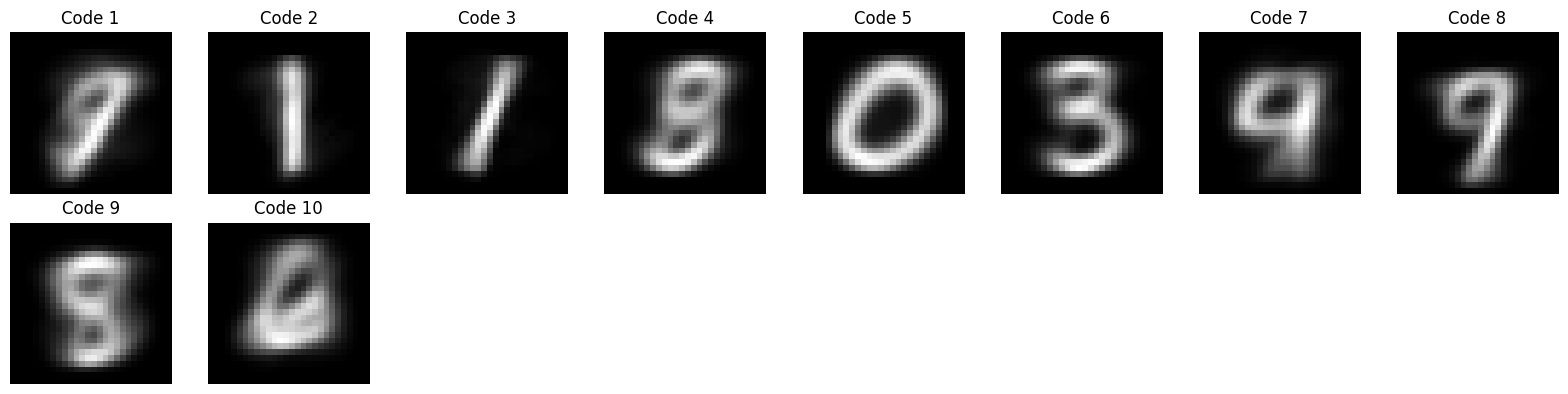

Epoch [71/100], Total Loss: 0.0710, Rec Loss: 0.0551, VQ Loss: 0.0159
Epoch [72/100], Total Loss: 0.0708, Rec Loss: 0.0553, VQ Loss: 0.0155
Epoch [73/100], Total Loss: 0.0703, Rec Loss: 0.0550, VQ Loss: 0.0152
Epoch [74/100], Total Loss: 0.0700, Rec Loss: 0.0549, VQ Loss: 0.0151
Epoch [75/100], Total Loss: 0.0699, Rec Loss: 0.0549, VQ Loss: 0.0150
Epoch [76/100], Total Loss: 0.0702, Rec Loss: 0.0552, VQ Loss: 0.0150
Epoch [77/100], Total Loss: 0.0702, Rec Loss: 0.0551, VQ Loss: 0.0151
Epoch [78/100], Total Loss: 0.0703, Rec Loss: 0.0550, VQ Loss: 0.0153


KeyboardInterrupt: 

In [ ]:
#Basic Descriptor-Decoder
from functools import total_ordering

# Hyperparameters
input_dim = 784  # for MNIST
hidden_dim = 256
embedding_dim = 64
num_embeddings = 10
output_dim = 784  # same as input_dim for reconstruction
learning_rate = 1e-4
num_epochs = 100
batch_size = 256

# Choose a dataset (e.g., MNIST)
data, _ = datasets["MNIST"]

# Initialize models
descriptor_model = Descriptor(input_dim, hidden_dim, num_embeddings, embedding_dim)
decoder_model = Decoder(embedding_dim, hidden_dim, output_dim)

# Optimizers
optimizer = torch.optim.Adam(list(descriptor_model.parameters()) + list(decoder_model.parameters()), lr=learning_rate)

# Loss functions
mse_loss = nn.MSELoss()

visualize_codebook_decodings(descriptor_model, decoder_model, image_shape=(28, 28))

# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size]

        optimizer.zero_grad()

        # Forward pass through descriptor
        z, quantized, vq_loss, _ = descriptor_model(batch_data)

        # Forward pass through decoder
        reconstructed = decoder_model(quantized)

        # Compute losses
        reconstruction_loss = mse_loss(reconstructed, batch_data)
        total_loss = reconstruction_loss + vq_loss

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.4f}, Rec Loss: {reconstruction_loss.item():.4f}, VQ Loss: {vq_loss.item():.4f}")

    if (epoch + 1) % 10 == 0:
        visualize_codebook_decodings(descriptor_model, decoder_model, image_shape=(28, 28))

Discrimination Game Training:

Descriptor and Discriminator jointly trained.

Decoder separately trained in order to visualise descriptor codebook in image space

*It is interesting to inspect the evolution over time of the decoded codes from the codebook*

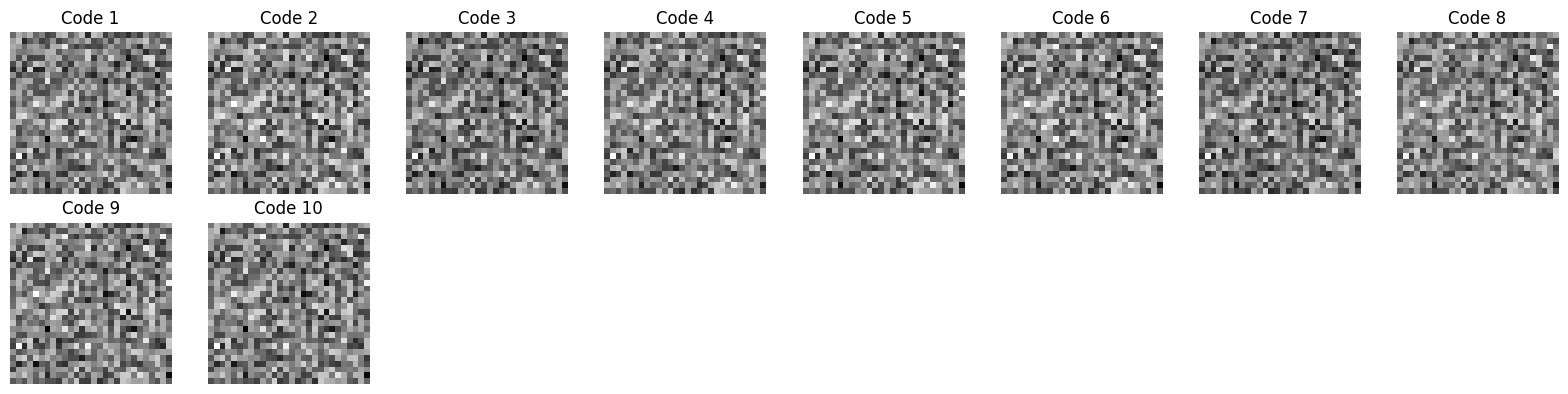

Epoch [1/200], Desc/Disc Loss: 13.6845, Real Loss: 0.4729, Fake Loss: 0.5881, VQ Loss: 12.6235, Decoder Loss: 0.0708
Epoch [2/200], Desc/Disc Loss: 8.6811, Real Loss: 0.4299, Fake Loss: 0.5536, VQ Loss: 7.6976, Decoder Loss: 0.0695
Epoch [3/200], Desc/Disc Loss: 12.3906, Real Loss: 0.3980, Fake Loss: 0.5210, VQ Loss: 11.4716, Decoder Loss: 0.0646
Epoch [4/200], Desc/Disc Loss: 7.6762, Real Loss: 0.3589, Fake Loss: 0.4043, VQ Loss: 6.9130, Decoder Loss: 0.0618
Epoch [5/200], Desc/Disc Loss: 4.7779, Real Loss: 0.3065, Fake Loss: 0.4945, VQ Loss: 3.9770, Decoder Loss: 0.0617
Epoch [6/200], Desc/Disc Loss: 2.7324, Real Loss: 0.3880, Fake Loss: 0.4281, VQ Loss: 1.9163, Decoder Loss: 0.0614
Epoch [7/200], Desc/Disc Loss: 2.2376, Real Loss: 0.2885, Fake Loss: 0.6207, VQ Loss: 1.3285, Decoder Loss: 0.0621
Epoch [8/200], Desc/Disc Loss: 1.7096, Real Loss: 0.3181, Fake Loss: 0.4208, VQ Loss: 0.9706, Decoder Loss: 0.0621
Epoch [9/200], Desc/Disc Loss: 1.5930, Real Loss: 0.2953, Fake Loss: 0.4547,

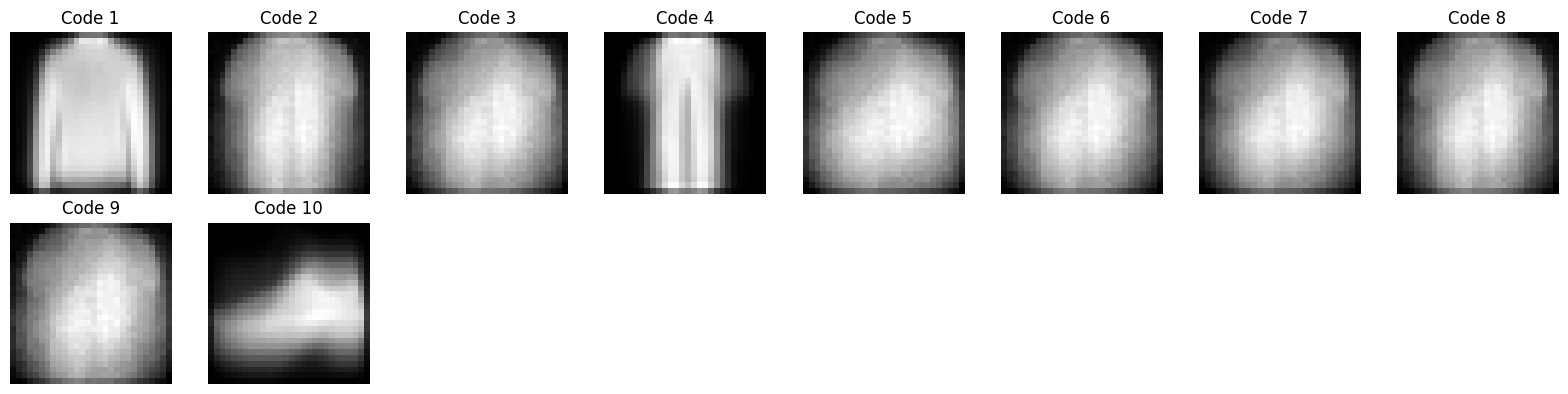

Epoch [11/200], Desc/Disc Loss: 1.4655, Real Loss: 0.2854, Fake Loss: 0.5355, VQ Loss: 0.6446, Decoder Loss: 0.0611
Epoch [12/200], Desc/Disc Loss: 1.3282, Real Loss: 0.3523, Fake Loss: 0.4331, VQ Loss: 0.5427, Decoder Loss: 0.0606
Epoch [13/200], Desc/Disc Loss: 1.2807, Real Loss: 0.2562, Fake Loss: 0.5108, VQ Loss: 0.5138, Decoder Loss: 0.0596
Epoch [14/200], Desc/Disc Loss: 1.3543, Real Loss: 0.3175, Fake Loss: 0.4942, VQ Loss: 0.5426, Decoder Loss: 0.0594
Epoch [15/200], Desc/Disc Loss: 1.6721, Real Loss: 0.2815, Fake Loss: 0.5687, VQ Loss: 0.8219, Decoder Loss: 0.0599
Epoch [16/200], Desc/Disc Loss: 1.9884, Real Loss: 0.2742, Fake Loss: 0.4367, VQ Loss: 1.2774, Decoder Loss: 0.0609
Epoch [17/200], Desc/Disc Loss: 2.6670, Real Loss: 0.2581, Fake Loss: 0.3479, VQ Loss: 2.0610, Decoder Loss: 0.0589
Epoch [18/200], Desc/Disc Loss: 2.1634, Real Loss: 0.2638, Fake Loss: 0.3608, VQ Loss: 1.5387, Decoder Loss: 0.0584
Epoch [19/200], Desc/Disc Loss: 1.8937, Real Loss: 0.2163, Fake Loss: 0.

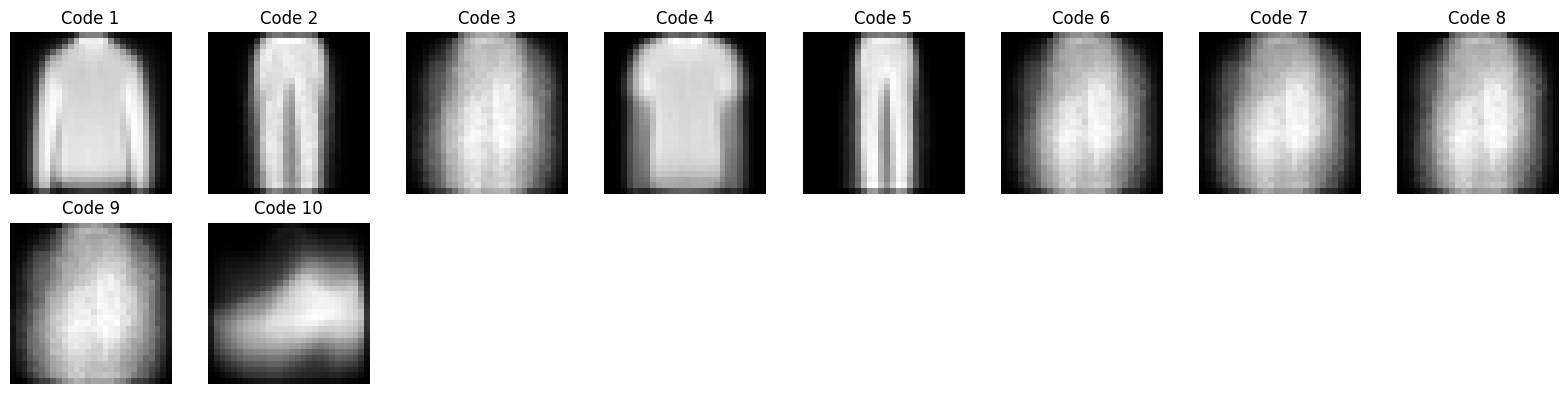

Epoch [21/200], Desc/Disc Loss: 1.6553, Real Loss: 0.2256, Fake Loss: 0.3978, VQ Loss: 1.0319, Decoder Loss: 0.0577
Epoch [22/200], Desc/Disc Loss: 1.5755, Real Loss: 0.2995, Fake Loss: 0.3717, VQ Loss: 0.9043, Decoder Loss: 0.0573
Epoch [23/200], Desc/Disc Loss: 1.3505, Real Loss: 0.2367, Fake Loss: 0.3274, VQ Loss: 0.7864, Decoder Loss: 0.0572
Epoch [24/200], Desc/Disc Loss: 1.4747, Real Loss: 0.2926, Fake Loss: 0.3424, VQ Loss: 0.8397, Decoder Loss: 0.0569
Epoch [25/200], Desc/Disc Loss: 1.4696, Real Loss: 0.2650, Fake Loss: 0.3703, VQ Loss: 0.8343, Decoder Loss: 0.0578
Epoch [26/200], Desc/Disc Loss: 1.5168, Real Loss: 0.2460, Fake Loss: 0.4576, VQ Loss: 0.8132, Decoder Loss: 0.0572
Epoch [27/200], Desc/Disc Loss: 1.4457, Real Loss: 0.2267, Fake Loss: 0.4851, VQ Loss: 0.7338, Decoder Loss: 0.0557
Epoch [28/200], Desc/Disc Loss: 1.3449, Real Loss: 0.2705, Fake Loss: 0.3819, VQ Loss: 0.6925, Decoder Loss: 0.0560
Epoch [29/200], Desc/Disc Loss: 1.4188, Real Loss: 0.2071, Fake Loss: 0.

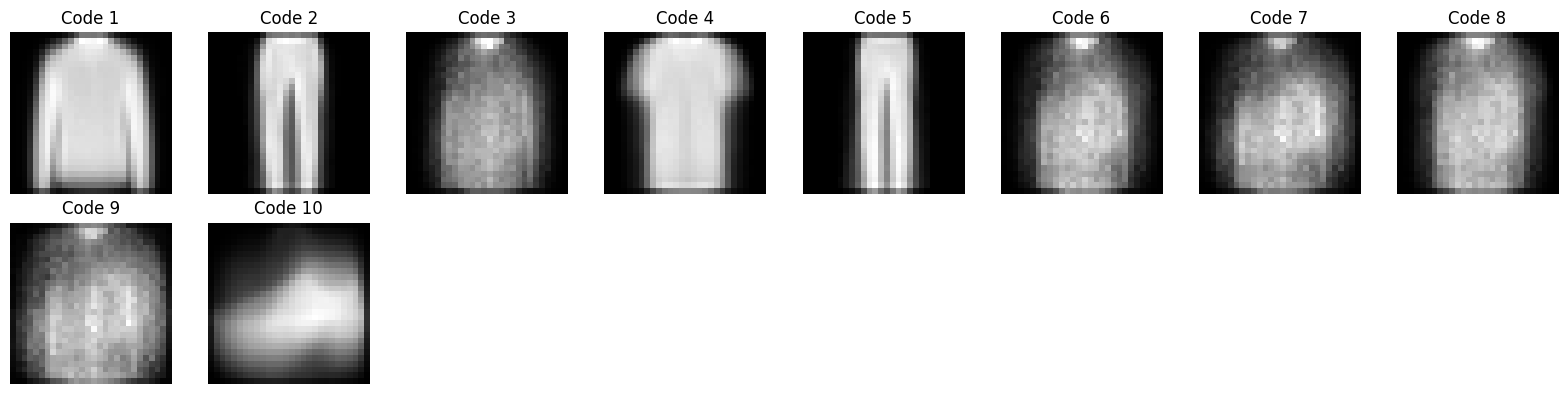

Epoch [31/200], Desc/Disc Loss: 1.1968, Real Loss: 0.2345, Fake Loss: 0.2686, VQ Loss: 0.6937, Decoder Loss: 0.0578
Epoch [32/200], Desc/Disc Loss: 1.3580, Real Loss: 0.2325, Fake Loss: 0.4141, VQ Loss: 0.7115, Decoder Loss: 0.0557
Epoch [33/200], Desc/Disc Loss: 1.3468, Real Loss: 0.2198, Fake Loss: 0.4229, VQ Loss: 0.7040, Decoder Loss: 0.0557
Epoch [34/200], Desc/Disc Loss: 1.3185, Real Loss: 0.2385, Fake Loss: 0.3669, VQ Loss: 0.7131, Decoder Loss: 0.0570
Epoch [35/200], Desc/Disc Loss: 1.3877, Real Loss: 0.2391, Fake Loss: 0.4163, VQ Loss: 0.7323, Decoder Loss: 0.0598
Epoch [36/200], Desc/Disc Loss: 1.2544, Real Loss: 0.2186, Fake Loss: 0.3166, VQ Loss: 0.7192, Decoder Loss: 0.0609
Epoch [37/200], Desc/Disc Loss: 1.5165, Real Loss: 0.3098, Fake Loss: 0.3453, VQ Loss: 0.8613, Decoder Loss: 0.0616
Epoch [38/200], Desc/Disc Loss: 1.6047, Real Loss: 0.2768, Fake Loss: 0.3169, VQ Loss: 1.0111, Decoder Loss: 0.0617
Epoch [39/200], Desc/Disc Loss: 1.8091, Real Loss: 0.2281, Fake Loss: 0.

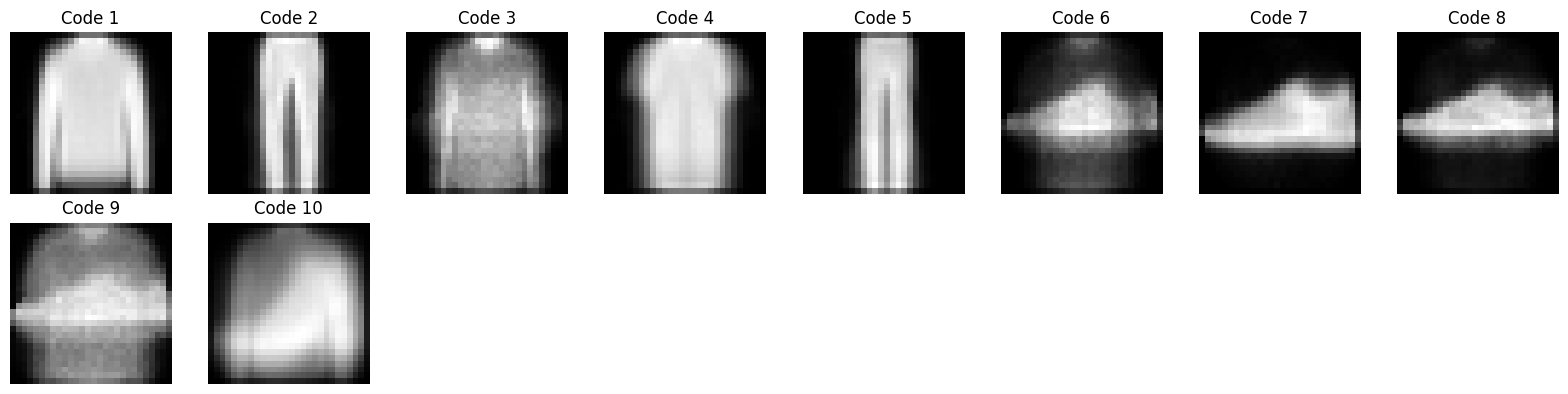

Epoch [41/200], Desc/Disc Loss: 1.8221, Real Loss: 0.2149, Fake Loss: 0.4286, VQ Loss: 1.1786, Decoder Loss: 0.0601
Epoch [42/200], Desc/Disc Loss: 1.8346, Real Loss: 0.1916, Fake Loss: 0.4463, VQ Loss: 1.1967, Decoder Loss: 0.0582
Epoch [43/200], Desc/Disc Loss: 1.9790, Real Loss: 0.2184, Fake Loss: 0.4671, VQ Loss: 1.2934, Decoder Loss: 0.0584
Epoch [44/200], Desc/Disc Loss: 1.9508, Real Loss: 0.1663, Fake Loss: 0.3307, VQ Loss: 1.4537, Decoder Loss: 0.0563
Epoch [45/200], Desc/Disc Loss: 2.1225, Real Loss: 0.1676, Fake Loss: 0.3549, VQ Loss: 1.5999, Decoder Loss: 0.0566
Epoch [46/200], Desc/Disc Loss: 2.4451, Real Loss: 0.2249, Fake Loss: 0.2924, VQ Loss: 1.9279, Decoder Loss: 0.0590
Epoch [47/200], Desc/Disc Loss: 2.3210, Real Loss: 0.2284, Fake Loss: 0.3645, VQ Loss: 1.7282, Decoder Loss: 0.0612
Epoch [48/200], Desc/Disc Loss: 2.2304, Real Loss: 0.1735, Fake Loss: 0.4253, VQ Loss: 1.6317, Decoder Loss: 0.0594
Epoch [49/200], Desc/Disc Loss: 2.1470, Real Loss: 0.1746, Fake Loss: 0.

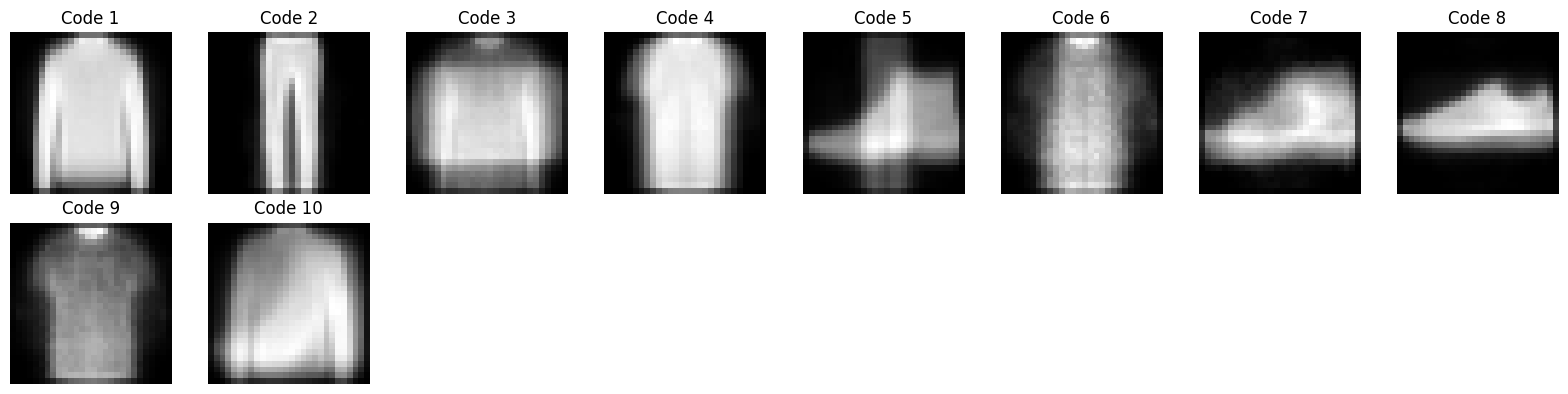

Epoch [51/200], Desc/Disc Loss: 1.7885, Real Loss: 0.1823, Fake Loss: 0.3563, VQ Loss: 1.2498, Decoder Loss: 0.0569
Epoch [52/200], Desc/Disc Loss: 1.6959, Real Loss: 0.1910, Fake Loss: 0.3083, VQ Loss: 1.1967, Decoder Loss: 0.0563
Epoch [53/200], Desc/Disc Loss: 1.7791, Real Loss: 0.1977, Fake Loss: 0.3900, VQ Loss: 1.1914, Decoder Loss: 0.0567
Epoch [54/200], Desc/Disc Loss: 1.6672, Real Loss: 0.1560, Fake Loss: 0.4155, VQ Loss: 1.0957, Decoder Loss: 0.0566
Epoch [55/200], Desc/Disc Loss: 1.5518, Real Loss: 0.1538, Fake Loss: 0.3746, VQ Loss: 1.0234, Decoder Loss: 0.0570
Epoch [56/200], Desc/Disc Loss: 1.6486, Real Loss: 0.2214, Fake Loss: 0.3523, VQ Loss: 1.0748, Decoder Loss: 0.0573
Epoch [57/200], Desc/Disc Loss: 1.5474, Real Loss: 0.2059, Fake Loss: 0.3011, VQ Loss: 1.0404, Decoder Loss: 0.0583
Epoch [58/200], Desc/Disc Loss: 1.6266, Real Loss: 0.2076, Fake Loss: 0.4090, VQ Loss: 1.0100, Decoder Loss: 0.0582
Epoch [59/200], Desc/Disc Loss: 1.5825, Real Loss: 0.2276, Fake Loss: 0.

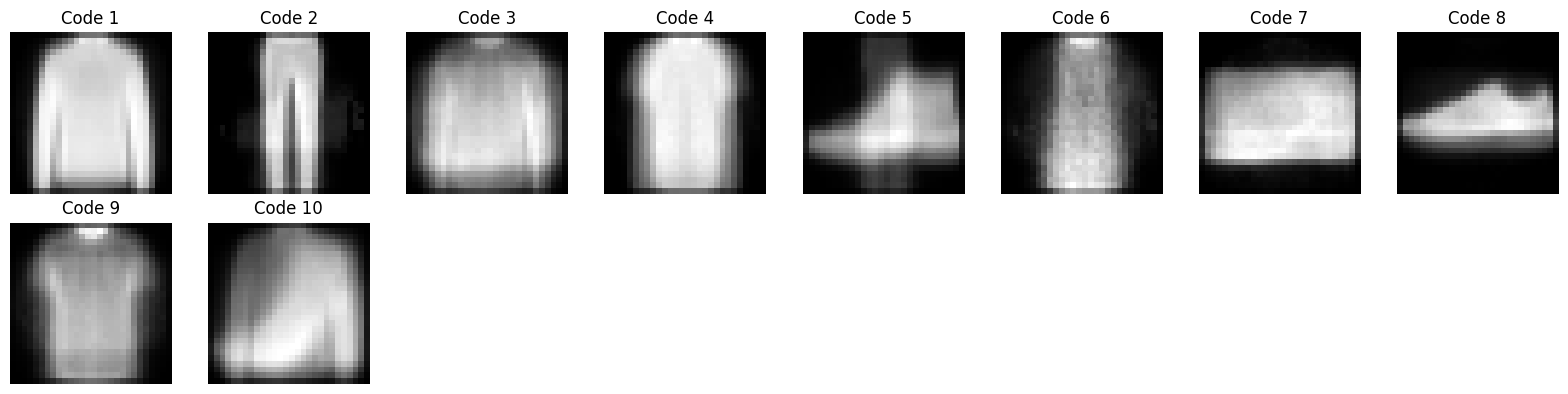

Epoch [61/200], Desc/Disc Loss: 1.8820, Real Loss: 0.1780, Fake Loss: 0.3653, VQ Loss: 1.3387, Decoder Loss: 0.0599
Epoch [62/200], Desc/Disc Loss: 2.1113, Real Loss: 0.1800, Fake Loss: 0.3230, VQ Loss: 1.6084, Decoder Loss: 0.0599
Epoch [63/200], Desc/Disc Loss: 2.2085, Real Loss: 0.1634, Fake Loss: 0.5055, VQ Loss: 1.5396, Decoder Loss: 0.0602
Epoch [64/200], Desc/Disc Loss: 2.4450, Real Loss: 0.1612, Fake Loss: 0.4097, VQ Loss: 1.8741, Decoder Loss: 0.0587
Epoch [65/200], Desc/Disc Loss: 2.5665, Real Loss: 0.1987, Fake Loss: 0.4075, VQ Loss: 1.9603, Decoder Loss: 0.0591
Epoch [66/200], Desc/Disc Loss: 2.3592, Real Loss: 0.2114, Fake Loss: 0.2376, VQ Loss: 1.9103, Decoder Loss: 0.0581
Epoch [67/200], Desc/Disc Loss: 2.6703, Real Loss: 0.1783, Fake Loss: 0.3110, VQ Loss: 2.1809, Decoder Loss: 0.0575
Epoch [68/200], Desc/Disc Loss: 2.6297, Real Loss: 0.1649, Fake Loss: 0.2916, VQ Loss: 2.1732, Decoder Loss: 0.0593
Epoch [69/200], Desc/Disc Loss: 2.8124, Real Loss: 0.1569, Fake Loss: 0.

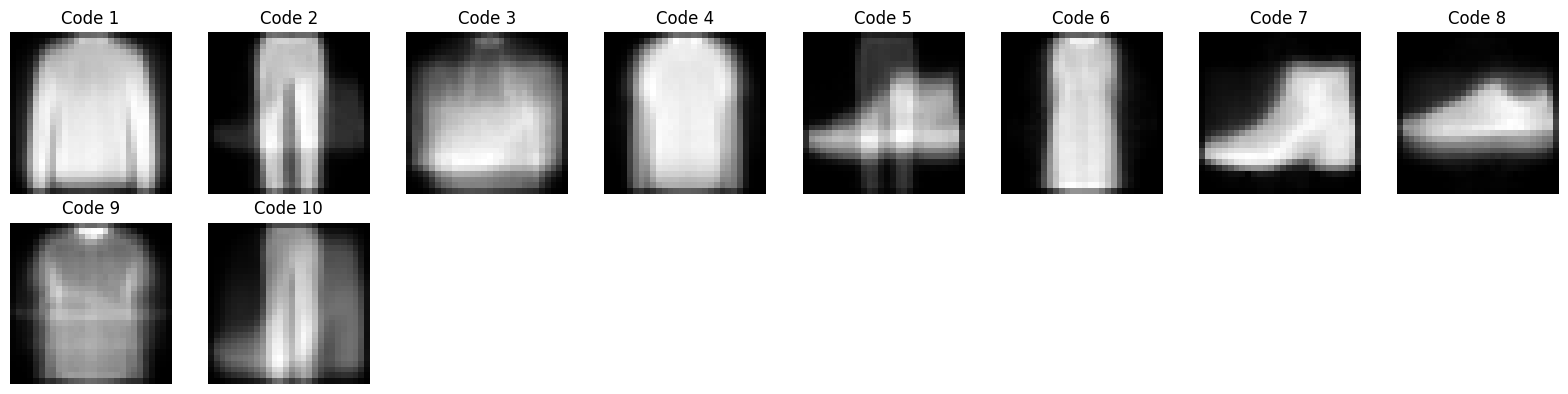

Epoch [71/200], Desc/Disc Loss: 2.7277, Real Loss: 0.1804, Fake Loss: 0.3780, VQ Loss: 2.1693, Decoder Loss: 0.0576
Epoch [72/200], Desc/Disc Loss: 2.5965, Real Loss: 0.1771, Fake Loss: 0.3520, VQ Loss: 2.0673, Decoder Loss: 0.0565
Epoch [73/200], Desc/Disc Loss: 2.8788, Real Loss: 0.2058, Fake Loss: 0.2937, VQ Loss: 2.3794, Decoder Loss: 0.0580
Epoch [74/200], Desc/Disc Loss: 2.8122, Real Loss: 0.1395, Fake Loss: 0.4003, VQ Loss: 2.2724, Decoder Loss: 0.0548
Epoch [75/200], Desc/Disc Loss: 2.6598, Real Loss: 0.1677, Fake Loss: 0.4992, VQ Loss: 1.9930, Decoder Loss: 0.0542
Epoch [76/200], Desc/Disc Loss: 2.2852, Real Loss: 0.1879, Fake Loss: 0.4119, VQ Loss: 1.6854, Decoder Loss: 0.0553
Epoch [77/200], Desc/Disc Loss: 2.0415, Real Loss: 0.2057, Fake Loss: 0.3255, VQ Loss: 1.5103, Decoder Loss: 0.0537
Epoch [78/200], Desc/Disc Loss: 1.7835, Real Loss: 0.1501, Fake Loss: 0.3009, VQ Loss: 1.3324, Decoder Loss: 0.0522
Epoch [79/200], Desc/Disc Loss: 1.6581, Real Loss: 0.1853, Fake Loss: 0.

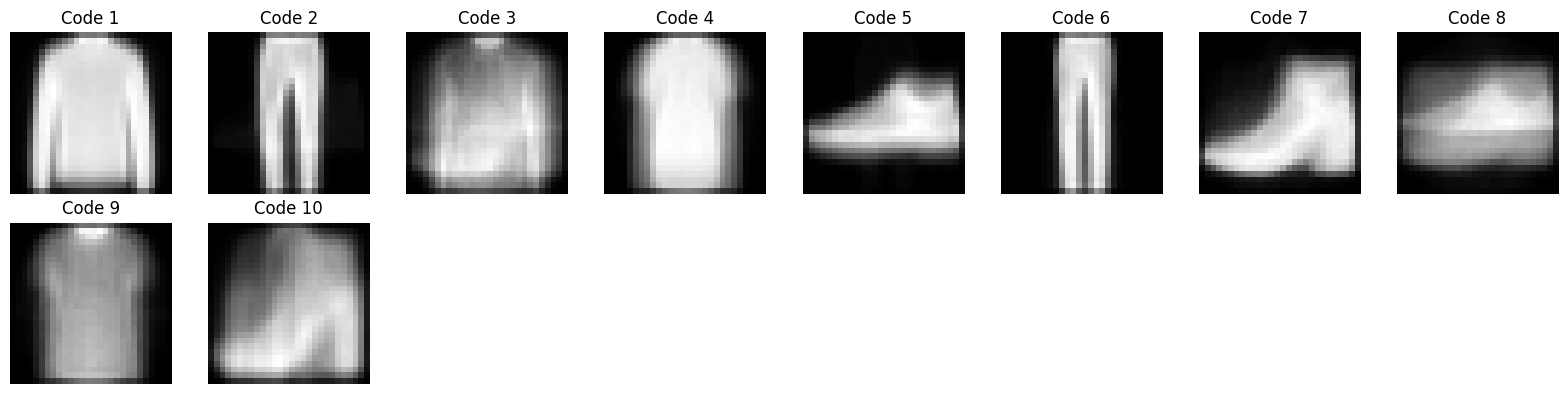

Epoch [81/200], Desc/Disc Loss: 1.6871, Real Loss: 0.1681, Fake Loss: 0.3242, VQ Loss: 1.1948, Decoder Loss: 0.0504
Epoch [82/200], Desc/Disc Loss: 1.5791, Real Loss: 0.1278, Fake Loss: 0.4038, VQ Loss: 1.0475, Decoder Loss: 0.0506
Epoch [83/200], Desc/Disc Loss: 1.4261, Real Loss: 0.1778, Fake Loss: 0.2560, VQ Loss: 0.9923, Decoder Loss: 0.0510
Epoch [84/200], Desc/Disc Loss: 1.6001, Real Loss: 0.1347, Fake Loss: 0.5052, VQ Loss: 0.9601, Decoder Loss: 0.0504
Epoch [85/200], Desc/Disc Loss: 1.5154, Real Loss: 0.1655, Fake Loss: 0.3577, VQ Loss: 0.9922, Decoder Loss: 0.0505
Epoch [86/200], Desc/Disc Loss: 1.3924, Real Loss: 0.1554, Fake Loss: 0.2497, VQ Loss: 0.9873, Decoder Loss: 0.0505
Epoch [87/200], Desc/Disc Loss: 1.4625, Real Loss: 0.1393, Fake Loss: 0.3771, VQ Loss: 0.9460, Decoder Loss: 0.0522
Epoch [88/200], Desc/Disc Loss: 1.4996, Real Loss: 0.1543, Fake Loss: 0.3628, VQ Loss: 0.9825, Decoder Loss: 0.0522
Epoch [89/200], Desc/Disc Loss: 1.4962, Real Loss: 0.1642, Fake Loss: 0.

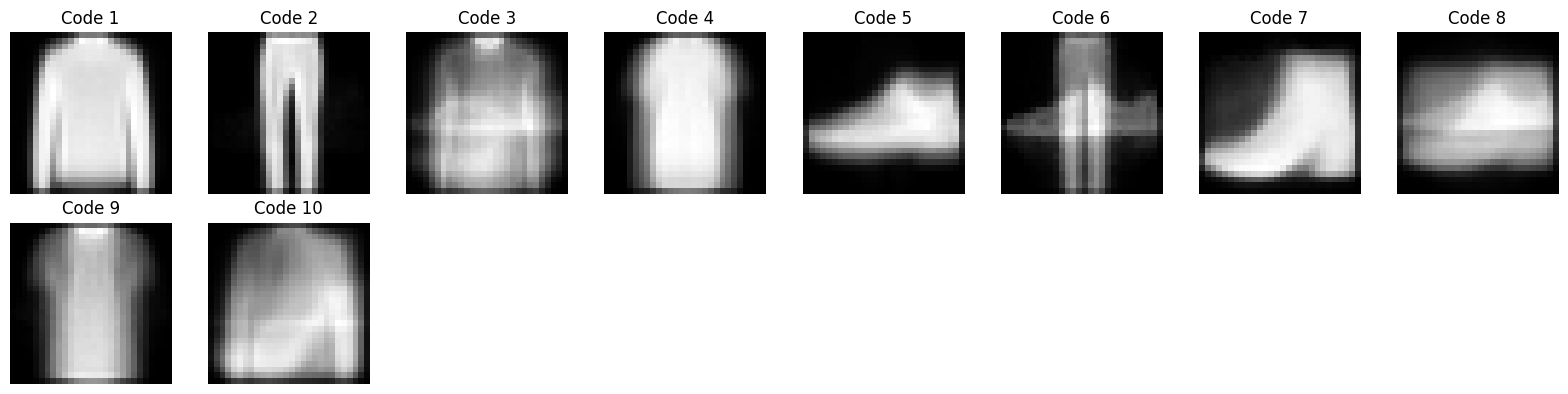

Epoch [91/200], Desc/Disc Loss: 1.4405, Real Loss: 0.1842, Fake Loss: 0.2446, VQ Loss: 1.0117, Decoder Loss: 0.0521
Epoch [92/200], Desc/Disc Loss: 1.2907, Real Loss: 0.1532, Fake Loss: 0.1712, VQ Loss: 0.9664, Decoder Loss: 0.0525
Epoch [93/200], Desc/Disc Loss: 1.5373, Real Loss: 0.1809, Fake Loss: 0.3750, VQ Loss: 0.9814, Decoder Loss: 0.0531
Epoch [94/200], Desc/Disc Loss: 1.6074, Real Loss: 0.1896, Fake Loss: 0.3466, VQ Loss: 1.0712, Decoder Loss: 0.0527
Epoch [95/200], Desc/Disc Loss: 1.4293, Real Loss: 0.1242, Fake Loss: 0.2566, VQ Loss: 1.0485, Decoder Loss: 0.0530
Epoch [96/200], Desc/Disc Loss: 1.4137, Real Loss: 0.1243, Fake Loss: 0.2777, VQ Loss: 1.0117, Decoder Loss: 0.0529
Epoch [97/200], Desc/Disc Loss: 1.4365, Real Loss: 0.1467, Fake Loss: 0.3067, VQ Loss: 0.9831, Decoder Loss: 0.0522
Epoch [98/200], Desc/Disc Loss: 1.3136, Real Loss: 0.1619, Fake Loss: 0.2898, VQ Loss: 0.8619, Decoder Loss: 0.0538
Epoch [99/200], Desc/Disc Loss: 1.3092, Real Loss: 0.1682, Fake Loss: 0.

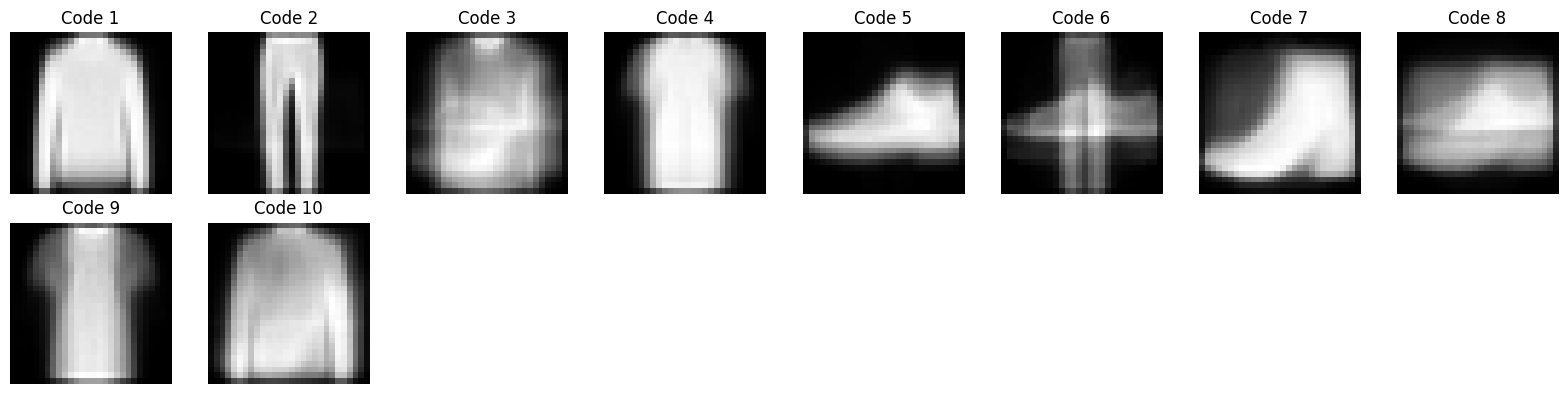

Epoch [101/200], Desc/Disc Loss: 1.2565, Real Loss: 0.1598, Fake Loss: 0.3227, VQ Loss: 0.7741, Decoder Loss: 0.0523
Epoch [102/200], Desc/Disc Loss: 1.3218, Real Loss: 0.1766, Fake Loss: 0.3924, VQ Loss: 0.7528, Decoder Loss: 0.0529
Epoch [103/200], Desc/Disc Loss: 1.0480, Real Loss: 0.1615, Fake Loss: 0.1946, VQ Loss: 0.6919, Decoder Loss: 0.0525
Epoch [104/200], Desc/Disc Loss: 1.2684, Real Loss: 0.1458, Fake Loss: 0.4747, VQ Loss: 0.6478, Decoder Loss: 0.0524
Epoch [105/200], Desc/Disc Loss: 1.0021, Real Loss: 0.1738, Fake Loss: 0.1851, VQ Loss: 0.6433, Decoder Loss: 0.0527
Epoch [106/200], Desc/Disc Loss: 1.0424, Real Loss: 0.1791, Fake Loss: 0.2534, VQ Loss: 0.6099, Decoder Loss: 0.0532
Epoch [107/200], Desc/Disc Loss: 1.1575, Real Loss: 0.1604, Fake Loss: 0.4053, VQ Loss: 0.5918, Decoder Loss: 0.0530
Epoch [108/200], Desc/Disc Loss: 1.0855, Real Loss: 0.1024, Fake Loss: 0.4443, VQ Loss: 0.5389, Decoder Loss: 0.0541
Epoch [109/200], Desc/Disc Loss: 0.9975, Real Loss: 0.1656, Fake

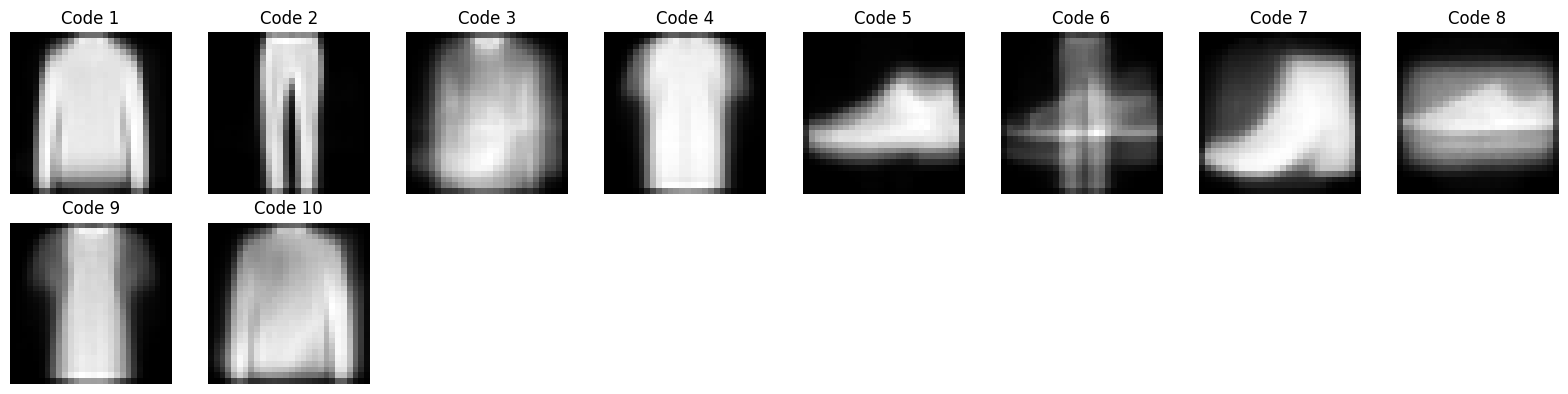

Epoch [111/200], Desc/Disc Loss: 0.9939, Real Loss: 0.1353, Fake Loss: 0.3267, VQ Loss: 0.5319, Decoder Loss: 0.0527
Epoch [112/200], Desc/Disc Loss: 0.8831, Real Loss: 0.1163, Fake Loss: 0.2459, VQ Loss: 0.5209, Decoder Loss: 0.0505
Epoch [113/200], Desc/Disc Loss: 0.8983, Real Loss: 0.1620, Fake Loss: 0.2156, VQ Loss: 0.5207, Decoder Loss: 0.0517
Epoch [114/200], Desc/Disc Loss: 0.8486, Real Loss: 0.1507, Fake Loss: 0.1812, VQ Loss: 0.5167, Decoder Loss: 0.0517
Epoch [115/200], Desc/Disc Loss: 0.9645, Real Loss: 0.1224, Fake Loss: 0.3542, VQ Loss: 0.4879, Decoder Loss: 0.0508
Epoch [116/200], Desc/Disc Loss: 0.8984, Real Loss: 0.1334, Fake Loss: 0.2628, VQ Loss: 0.5022, Decoder Loss: 0.0518
Epoch [117/200], Desc/Disc Loss: 0.8471, Real Loss: 0.1593, Fake Loss: 0.1862, VQ Loss: 0.5017, Decoder Loss: 0.0520
Epoch [118/200], Desc/Disc Loss: 0.8666, Real Loss: 0.1272, Fake Loss: 0.2406, VQ Loss: 0.4988, Decoder Loss: 0.0521
Epoch [119/200], Desc/Disc Loss: 1.0004, Real Loss: 0.1663, Fake

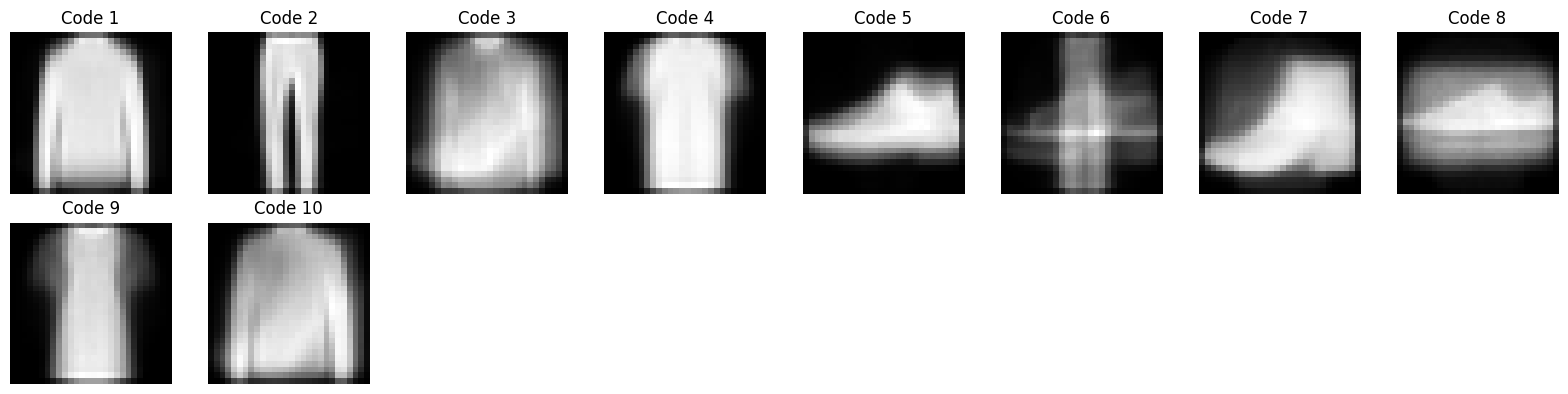

Epoch [121/200], Desc/Disc Loss: 0.8174, Real Loss: 0.1419, Fake Loss: 0.1836, VQ Loss: 0.4919, Decoder Loss: 0.0519
Epoch [122/200], Desc/Disc Loss: 0.8999, Real Loss: 0.1307, Fake Loss: 0.2735, VQ Loss: 0.4957, Decoder Loss: 0.0527
Epoch [123/200], Desc/Disc Loss: 0.9624, Real Loss: 0.1351, Fake Loss: 0.3414, VQ Loss: 0.4860, Decoder Loss: 0.0523
Epoch [124/200], Desc/Disc Loss: 0.8208, Real Loss: 0.1415, Fake Loss: 0.1959, VQ Loss: 0.4833, Decoder Loss: 0.0529
Epoch [125/200], Desc/Disc Loss: 0.9865, Real Loss: 0.1443, Fake Loss: 0.3542, VQ Loss: 0.4881, Decoder Loss: 0.0525
Epoch [126/200], Desc/Disc Loss: 0.8970, Real Loss: 0.1699, Fake Loss: 0.2122, VQ Loss: 0.5149, Decoder Loss: 0.0524
Epoch [127/200], Desc/Disc Loss: 0.9476, Real Loss: 0.1679, Fake Loss: 0.2661, VQ Loss: 0.5135, Decoder Loss: 0.0517
Epoch [128/200], Desc/Disc Loss: 0.9377, Real Loss: 0.1436, Fake Loss: 0.2740, VQ Loss: 0.5201, Decoder Loss: 0.0521
Epoch [129/200], Desc/Disc Loss: 0.9609, Real Loss: 0.1308, Fake

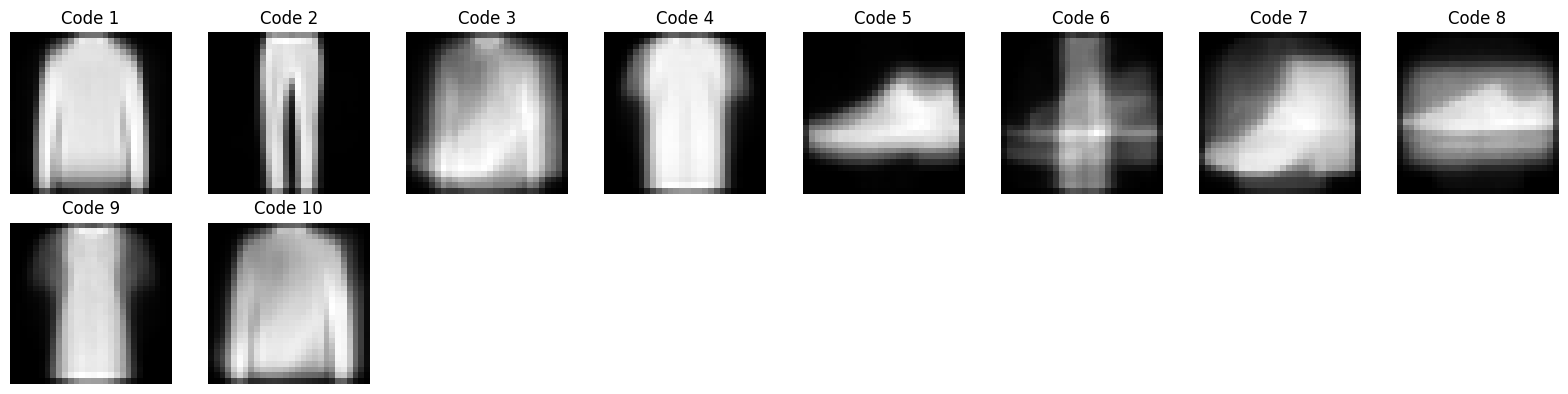

Epoch [131/200], Desc/Disc Loss: 0.9199, Real Loss: 0.1506, Fake Loss: 0.2480, VQ Loss: 0.5212, Decoder Loss: 0.0527
Epoch [132/200], Desc/Disc Loss: 0.8765, Real Loss: 0.1285, Fake Loss: 0.2375, VQ Loss: 0.5105, Decoder Loss: 0.0517
Epoch [133/200], Desc/Disc Loss: 0.8979, Real Loss: 0.1500, Fake Loss: 0.2391, VQ Loss: 0.5088, Decoder Loss: 0.0522
Epoch [134/200], Desc/Disc Loss: 0.8490, Real Loss: 0.0973, Fake Loss: 0.2439, VQ Loss: 0.5078, Decoder Loss: 0.0516
Epoch [135/200], Desc/Disc Loss: 0.9453, Real Loss: 0.1243, Fake Loss: 0.3065, VQ Loss: 0.5146, Decoder Loss: 0.0515
Epoch [136/200], Desc/Disc Loss: 0.8373, Real Loss: 0.1011, Fake Loss: 0.2477, VQ Loss: 0.4885, Decoder Loss: 0.0515
Epoch [137/200], Desc/Disc Loss: 1.0061, Real Loss: 0.1355, Fake Loss: 0.3970, VQ Loss: 0.4737, Decoder Loss: 0.0517
Epoch [138/200], Desc/Disc Loss: 0.9932, Real Loss: 0.1219, Fake Loss: 0.3798, VQ Loss: 0.4915, Decoder Loss: 0.0515
Epoch [139/200], Desc/Disc Loss: 0.8680, Real Loss: 0.1312, Fake

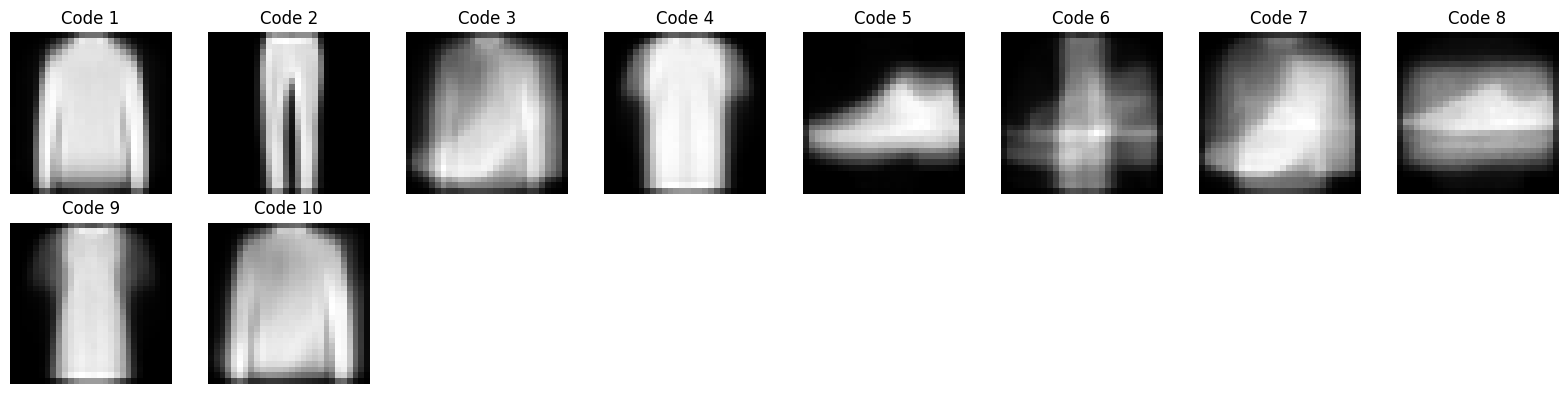

Epoch [141/200], Desc/Disc Loss: 1.0686, Real Loss: 0.1528, Fake Loss: 0.4077, VQ Loss: 0.5081, Decoder Loss: 0.0514
Epoch [142/200], Desc/Disc Loss: 0.9002, Real Loss: 0.0892, Fake Loss: 0.3291, VQ Loss: 0.4820, Decoder Loss: 0.0521
Epoch [143/200], Desc/Disc Loss: 0.9394, Real Loss: 0.1125, Fake Loss: 0.3067, VQ Loss: 0.5202, Decoder Loss: 0.0517
Epoch [144/200], Desc/Disc Loss: 1.0523, Real Loss: 0.1132, Fake Loss: 0.3971, VQ Loss: 0.5419, Decoder Loss: 0.0516
Epoch [145/200], Desc/Disc Loss: 0.9290, Real Loss: 0.1151, Fake Loss: 0.2588, VQ Loss: 0.5551, Decoder Loss: 0.0515
Epoch [146/200], Desc/Disc Loss: 1.0375, Real Loss: 0.0962, Fake Loss: 0.3295, VQ Loss: 0.6118, Decoder Loss: 0.0510
Epoch [147/200], Desc/Disc Loss: 0.9948, Real Loss: 0.1511, Fake Loss: 0.2482, VQ Loss: 0.5954, Decoder Loss: 0.0518
Epoch [148/200], Desc/Disc Loss: 0.9105, Real Loss: 0.0971, Fake Loss: 0.1656, VQ Loss: 0.6478, Decoder Loss: 0.0518
Epoch [149/200], Desc/Disc Loss: 1.0813, Real Loss: 0.1396, Fake

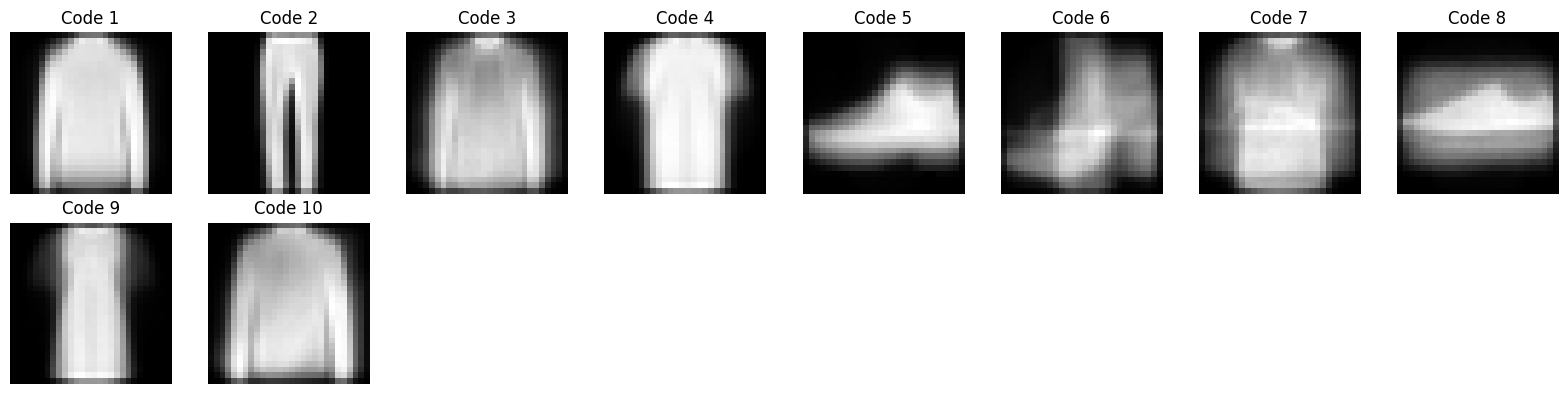

Epoch [151/200], Desc/Disc Loss: 1.1858, Real Loss: 0.1140, Fake Loss: 0.3852, VQ Loss: 0.6866, Decoder Loss: 0.0517
Epoch [152/200], Desc/Disc Loss: 1.0974, Real Loss: 0.1042, Fake Loss: 0.3181, VQ Loss: 0.6750, Decoder Loss: 0.0517
Epoch [153/200], Desc/Disc Loss: 1.1299, Real Loss: 0.1280, Fake Loss: 0.2989, VQ Loss: 0.7029, Decoder Loss: 0.0516
Epoch [154/200], Desc/Disc Loss: 1.2623, Real Loss: 0.1124, Fake Loss: 0.4906, VQ Loss: 0.6594, Decoder Loss: 0.0523
Epoch [155/200], Desc/Disc Loss: 1.0556, Real Loss: 0.1482, Fake Loss: 0.2420, VQ Loss: 0.6653, Decoder Loss: 0.0514
Epoch [156/200], Desc/Disc Loss: 0.9671, Real Loss: 0.1130, Fake Loss: 0.2128, VQ Loss: 0.6414, Decoder Loss: 0.0515
Epoch [157/200], Desc/Disc Loss: 1.0892, Real Loss: 0.1049, Fake Loss: 0.3373, VQ Loss: 0.6469, Decoder Loss: 0.0524
Epoch [158/200], Desc/Disc Loss: 0.9566, Real Loss: 0.1423, Fake Loss: 0.2149, VQ Loss: 0.5995, Decoder Loss: 0.0517
Epoch [159/200], Desc/Disc Loss: 1.0251, Real Loss: 0.1168, Fake

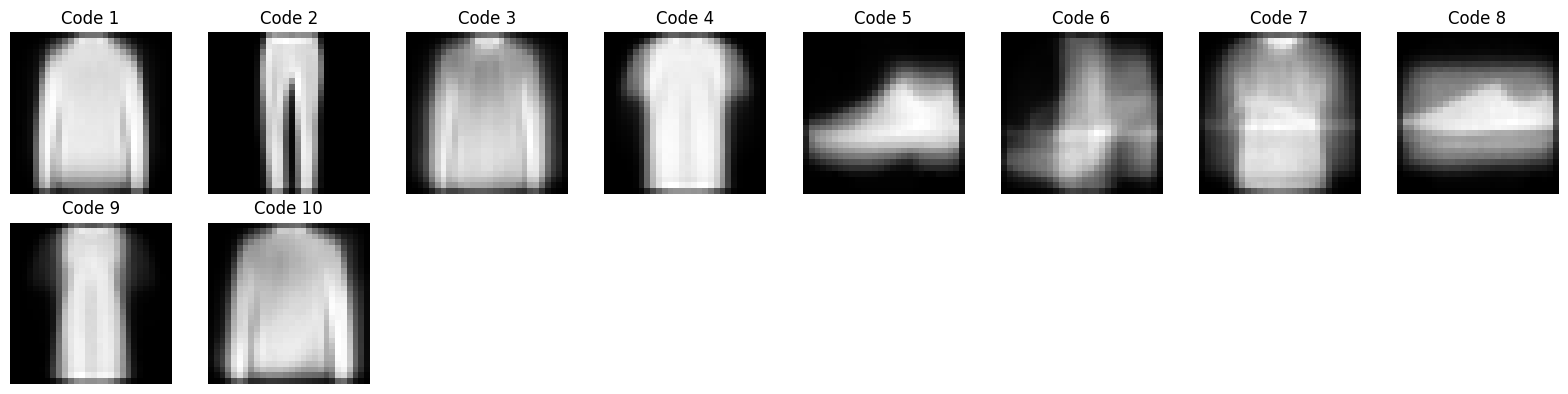

Epoch [161/200], Desc/Disc Loss: 1.0036, Real Loss: 0.1118, Fake Loss: 0.3139, VQ Loss: 0.5778, Decoder Loss: 0.0521
Epoch [162/200], Desc/Disc Loss: 1.1440, Real Loss: 0.1041, Fake Loss: 0.4338, VQ Loss: 0.6061, Decoder Loss: 0.0514
Epoch [163/200], Desc/Disc Loss: 0.9121, Real Loss: 0.0996, Fake Loss: 0.2194, VQ Loss: 0.5930, Decoder Loss: 0.0517
Epoch [164/200], Desc/Disc Loss: 1.0471, Real Loss: 0.1164, Fake Loss: 0.3776, VQ Loss: 0.5531, Decoder Loss: 0.0514
Epoch [165/200], Desc/Disc Loss: 0.9139, Real Loss: 0.1220, Fake Loss: 0.2335, VQ Loss: 0.5584, Decoder Loss: 0.0514
Epoch [166/200], Desc/Disc Loss: 0.9850, Real Loss: 0.1259, Fake Loss: 0.3013, VQ Loss: 0.5578, Decoder Loss: 0.0515
Epoch [167/200], Desc/Disc Loss: 1.1091, Real Loss: 0.1157, Fake Loss: 0.4565, VQ Loss: 0.5370, Decoder Loss: 0.0513
Epoch [168/200], Desc/Disc Loss: 0.9678, Real Loss: 0.1397, Fake Loss: 0.3189, VQ Loss: 0.5092, Decoder Loss: 0.0515
Epoch [169/200], Desc/Disc Loss: 1.0324, Real Loss: 0.1376, Fake

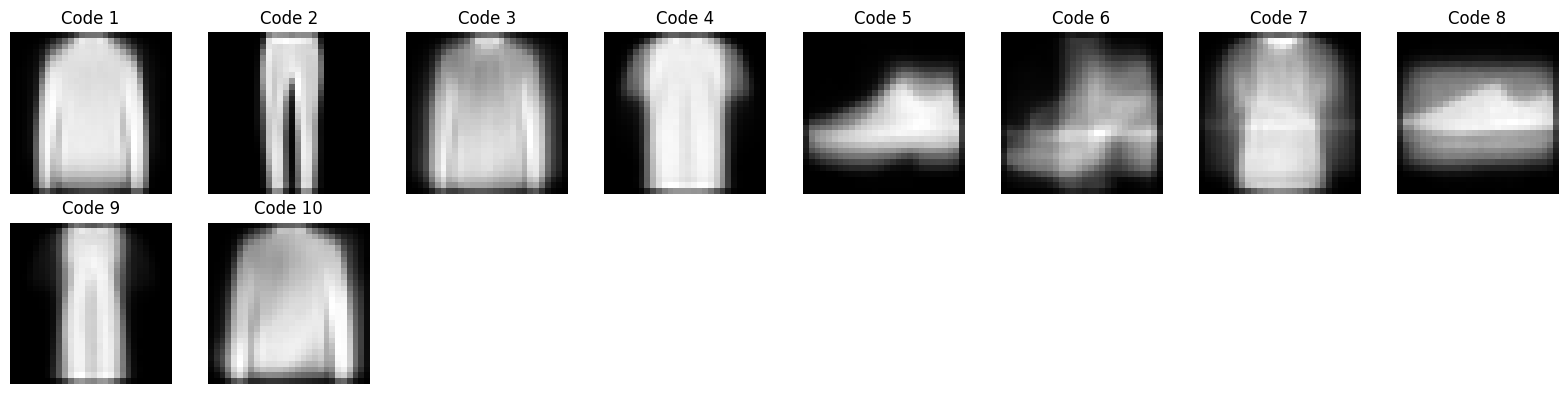

Epoch [171/200], Desc/Disc Loss: 0.8872, Real Loss: 0.1484, Fake Loss: 0.2584, VQ Loss: 0.4804, Decoder Loss: 0.0514
Epoch [172/200], Desc/Disc Loss: 0.7890, Real Loss: 0.1130, Fake Loss: 0.1790, VQ Loss: 0.4970, Decoder Loss: 0.0508
Epoch [173/200], Desc/Disc Loss: 0.8788, Real Loss: 0.1286, Fake Loss: 0.2705, VQ Loss: 0.4796, Decoder Loss: 0.0507
Epoch [174/200], Desc/Disc Loss: 0.9928, Real Loss: 0.1258, Fake Loss: 0.3987, VQ Loss: 0.4682, Decoder Loss: 0.0516
Epoch [175/200], Desc/Disc Loss: 0.8957, Real Loss: 0.1348, Fake Loss: 0.2663, VQ Loss: 0.4946, Decoder Loss: 0.0515
Epoch [176/200], Desc/Disc Loss: 0.9250, Real Loss: 0.1014, Fake Loss: 0.3405, VQ Loss: 0.4831, Decoder Loss: 0.0518
Epoch [177/200], Desc/Disc Loss: 0.9477, Real Loss: 0.1224, Fake Loss: 0.3355, VQ Loss: 0.4898, Decoder Loss: 0.0507
Epoch [178/200], Desc/Disc Loss: 0.9674, Real Loss: 0.1173, Fake Loss: 0.3787, VQ Loss: 0.4713, Decoder Loss: 0.0505
Epoch [179/200], Desc/Disc Loss: 0.9828, Real Loss: 0.1313, Fake

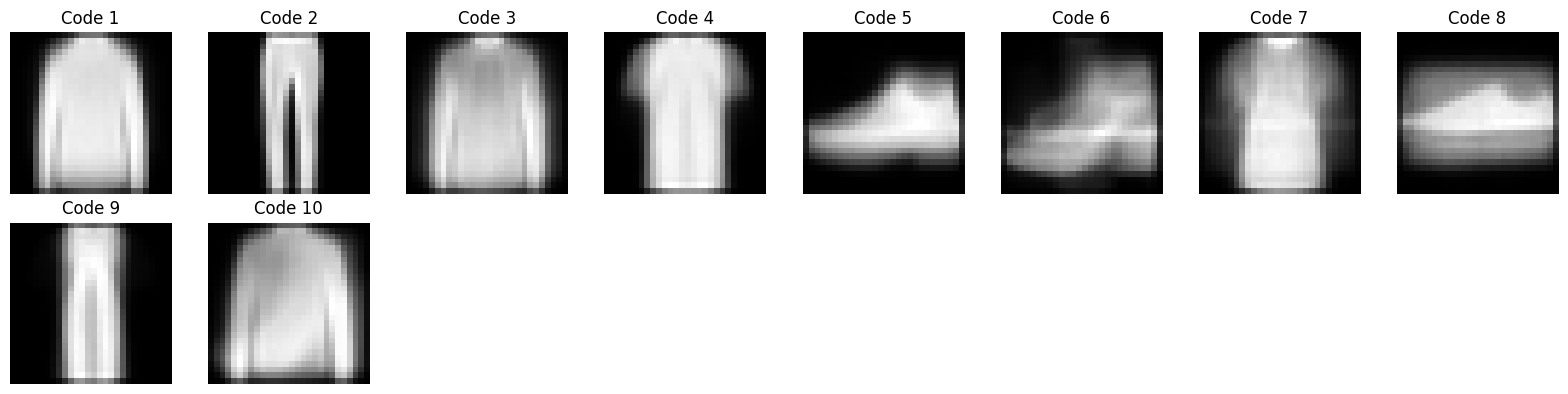

Epoch [181/200], Desc/Disc Loss: 0.8036, Real Loss: 0.1316, Fake Loss: 0.2174, VQ Loss: 0.4546, Decoder Loss: 0.0511
Epoch [182/200], Desc/Disc Loss: 0.7495, Real Loss: 0.1512, Fake Loss: 0.1366, VQ Loss: 0.4617, Decoder Loss: 0.0510
Epoch [183/200], Desc/Disc Loss: 0.8273, Real Loss: 0.1264, Fake Loss: 0.2375, VQ Loss: 0.4635, Decoder Loss: 0.0522
Epoch [184/200], Desc/Disc Loss: 0.7526, Real Loss: 0.1523, Fake Loss: 0.1410, VQ Loss: 0.4592, Decoder Loss: 0.0515
Epoch [185/200], Desc/Disc Loss: 0.8303, Real Loss: 0.1248, Fake Loss: 0.2767, VQ Loss: 0.4288, Decoder Loss: 0.0510
Epoch [186/200], Desc/Disc Loss: 0.7608, Real Loss: 0.1182, Fake Loss: 0.2056, VQ Loss: 0.4370, Decoder Loss: 0.0506
Epoch [187/200], Desc/Disc Loss: 0.8245, Real Loss: 0.1328, Fake Loss: 0.2512, VQ Loss: 0.4406, Decoder Loss: 0.0506
Epoch [188/200], Desc/Disc Loss: 0.8176, Real Loss: 0.1815, Fake Loss: 0.2119, VQ Loss: 0.4243, Decoder Loss: 0.0510
Epoch [189/200], Desc/Disc Loss: 0.9199, Real Loss: 0.1428, Fake

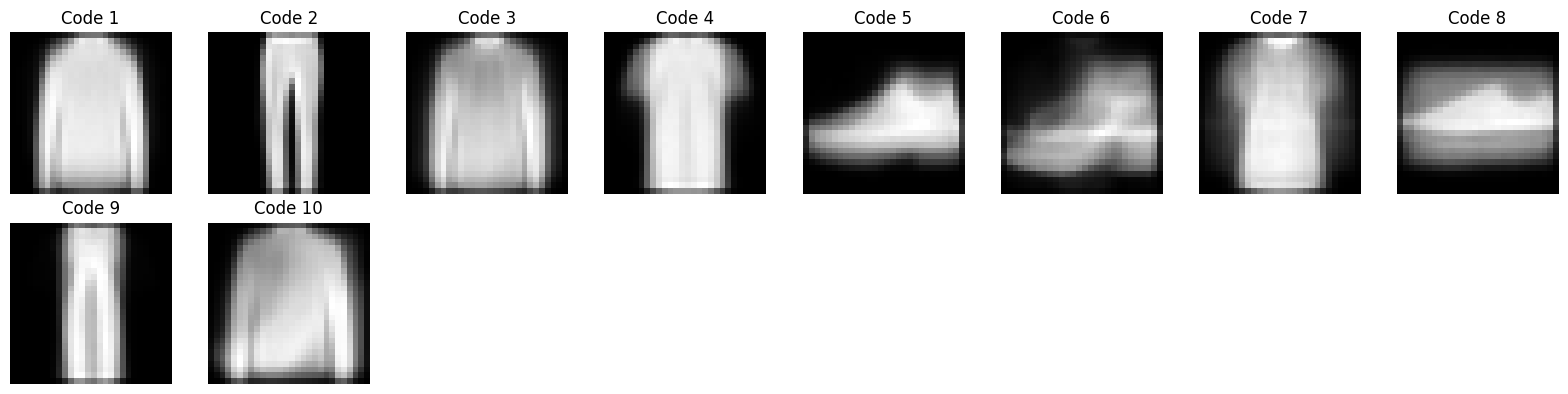

Epoch [191/200], Desc/Disc Loss: 1.0063, Real Loss: 0.1328, Fake Loss: 0.4435, VQ Loss: 0.4300, Decoder Loss: 0.0504
Epoch [192/200], Desc/Disc Loss: 0.8587, Real Loss: 0.1234, Fake Loss: 0.2836, VQ Loss: 0.4517, Decoder Loss: 0.0508
Epoch [193/200], Desc/Disc Loss: 0.8210, Real Loss: 0.1195, Fake Loss: 0.2765, VQ Loss: 0.4251, Decoder Loss: 0.0508
Epoch [194/200], Desc/Disc Loss: 0.8914, Real Loss: 0.0964, Fake Loss: 0.3720, VQ Loss: 0.4230, Decoder Loss: 0.0508
Epoch [195/200], Desc/Disc Loss: 0.7854, Real Loss: 0.1264, Fake Loss: 0.2202, VQ Loss: 0.4388, Decoder Loss: 0.0512
Epoch [196/200], Desc/Disc Loss: 0.8678, Real Loss: 0.1614, Fake Loss: 0.2645, VQ Loss: 0.4419, Decoder Loss: 0.0513
Epoch [197/200], Desc/Disc Loss: 0.8678, Real Loss: 0.1389, Fake Loss: 0.2974, VQ Loss: 0.4315, Decoder Loss: 0.0507
Epoch [198/200], Desc/Disc Loss: 0.9665, Real Loss: 0.1158, Fake Loss: 0.4179, VQ Loss: 0.4328, Decoder Loss: 0.0512
Epoch [199/200], Desc/Disc Loss: 0.7084, Real Loss: 0.1330, Fake

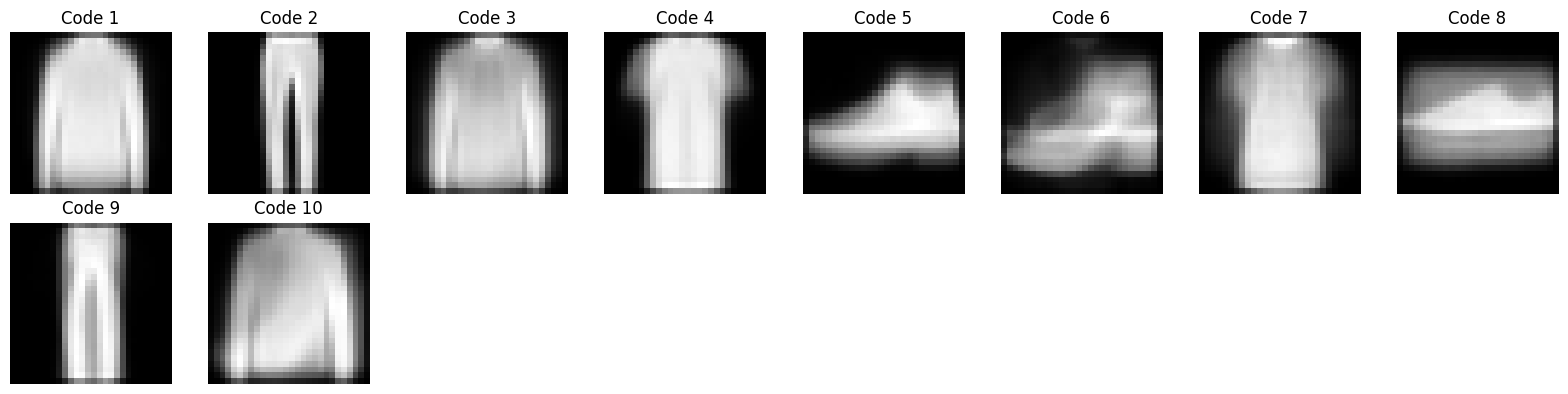

In [ ]:
# Hyperparameters
input_dim = 784
hidden_dim = 256
embedding_dim = 64
num_embeddings = 10

# Choose a dataset (e.g., MNIST)
data, _ = datasets["Fashion-MNIST"]

# Initialize models
descriptor_model = Descriptor(input_dim, hidden_dim, num_embeddings, embedding_dim)
discriminator_model = Discriminator(input_dim, embedding_dim, hidden_dim)
decoder_model = Decoder(embedding_dim, hidden_dim, input_dim)

# Optimizers
optimizer_desc = torch.optim.Adam(descriptor_model.parameters(), lr=1e-4)
optimizer_disc = torch.optim.Adam(discriminator_model.parameters(), lr=1e-4)
optimizer_decoder = torch.optim.Adam(decoder_model.parameters(), lr=1e-4)


# Loss function
criterion = nn.BCELoss()
mse_loss = nn.MSELoss()

# Training loop
num_epochs = 200
batch_size = 128



visualize_codebook_decodings(descriptor_model, decoder_model, image_shape=(28, 28))

for epoch in range(num_epochs):
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size]
        indices = torch.randperm(len(batch_data))
        shuffled_data = batch_data[indices]

        # Jointly train descriptor, discriminator

        optimizer_desc.zero_grad()
        optimizer_disc.zero_grad()
        optimizer_decoder.zero_grad()

        z, quantized, vq_loss, _ = descriptor_model(batch_data)

        disc_output_real = discriminator_model(vq_input=quantized, image_input=batch_data)
        disc_output_fake = discriminator_model(vq_input=quantized, image_input=shuffled_data)

        real_loss = criterion(disc_output_real, torch.ones_like(disc_output_real))
        fake_loss = criterion(disc_output_fake, torch.zeros_like(disc_output_fake))
        vq_loss = vq_loss * 0.1

        desc_disc_loss = vq_loss + real_loss + fake_loss

        desc_disc_loss.backward(retain_graph=True)

        # Separately train decoder
        reconstructed = decoder_model(quantized)
        decoder_loss = mse_loss(reconstructed, batch_data)

        decoder_loss.backward()

        optimizer_desc.step()
        optimizer_disc.step()
        optimizer_decoder.step()


    print(f"Epoch [{epoch+1}/{num_epochs}], Desc/Disc Loss: {desc_disc_loss.item():.4f}, Real Loss: {real_loss.item():.4f}, Fake Loss: {fake_loss.item():.4f}, VQ Loss: {vq_loss.item():.4f}, Decoder Loss: {decoder_loss.item():.4f}")
    if (epoch + 1) % 10 == 0:
        visualize_codebook_decodings(descriptor_model, decoder_model, image_shape=(28, 28))



Alternative training method -

JOINT TRAINING FOR DESC-DISC AND DECODER (
  
  PROBABLY NOT WANT WE WANT SINCE PERHAPS WE DON'T WANT RECONSTRUCTION LOSS TO AFFECT QUANTIZATION LEARNING ETC). IMPLEMENTED TO CHECK STUFF WORKS AS EXPECTED AND FOR MY INTUITIONS

*NB DONT RUN THIS IT DOESNT WORK, THE DECODER CURRENTLY DOES ALL THE WORK AND DISCRIMINATION GAME JUST HEDGES*

In [ ]:
'''# Hyperparameters
input_dim = 784
hidden_dim = 256
embedding_dim = 64
num_embeddings = 10

# Choose a dataset (e.g., MNIST)
data, _ = datasets["Fashion-MNIST"]

# Initialize models
descriptor_model = Descriptor(input_dim, hidden_dim, num_embeddings, embedding_dim)
discriminator_model = Discriminator(input_dim, embedding_dim, hidden_dim)
decoder_model = Decoder(embedding_dim, hidden_dim, input_dim)

# Optimizers
optimizer_desc = torch.optim.Adam(descriptor_model.parameters(), lr=1e-4)
optimizer_disc = torch.optim.Adam(discriminator_model.parameters(), lr=1e-4)
optimizer_decoder = torch.optim.Adam(decoder_model.parameters(), lr=1e-4)


# Loss function
criterion = nn.BCELoss()
mse_loss = nn.MSELoss()

# Training loop
num_epochs = 100
batch_size = 256


visualize_codebook_decodings(descriptor_model, decoder_model, image_shape=(28, 28))

for epoch in range(num_epochs):
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size]
        indices = torch.randperm(len(batch_data))
        shuffled_data = batch_data[indices]

        # Jointly train descriptor, discriminator and decoder
        optimizer_desc.zero_grad()
        optimizer_disc.zero_grad()
        optimizer_decoder.zero_grad()

        z, quantized, vq_loss, _ = descriptor_model(batch_data)

        disc_output_real = discriminator_model(vq_input=quantized, image_input=batch_data)
        disc_output_fake = discriminator_model(vq_input=quantized, image_input=shuffled_data)

        real_loss = criterion(disc_output_real, torch.ones_like(disc_output_real))
        fake_loss = criterion(disc_output_fake, torch.zeros_like(disc_output_fake))

        reconstructed = decoder_model(quantized)
        decoder_loss = mse_loss(reconstructed, batch_data)

        total_loss = vq_loss + decoder_loss #+ real_loss + fake_loss #currently playing with different weights to see which produces best training

        total_loss.backward()

        optimizer_desc.step()
        optimizer_disc.step()
        optimizer_decoder.step()


    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.4f}, Real Loss: {real_loss.item():.4f}, Fake Loss: {fake_loss.item():.4f}, VQ Loss: {vq_loss.item():.4f}, Decoder Loss: {decoder_loss.item():.4f}")
    if (epoch + 1) % 10 == 0:
        visualize_codebook_decodings(descriptor_model, decoder_model, image_shape=(28, 28))
'''


Discrimination Game Trial:

Desc-Disc model pair is fed exactly matching image pairs and non-matching image pairs.

Output on [0,1] interval of the discriminator model is attached to each pair to measure presence of first image in the second

It works well! Although not perfectly

Exact Pairs:


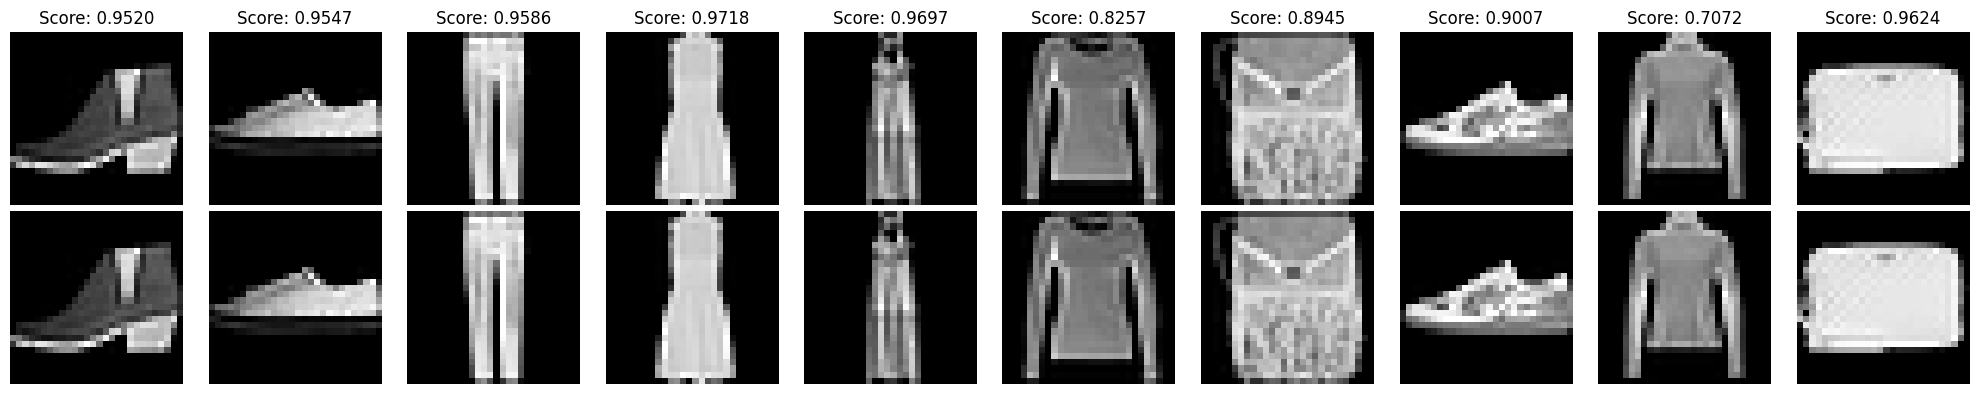


Different Pairs:


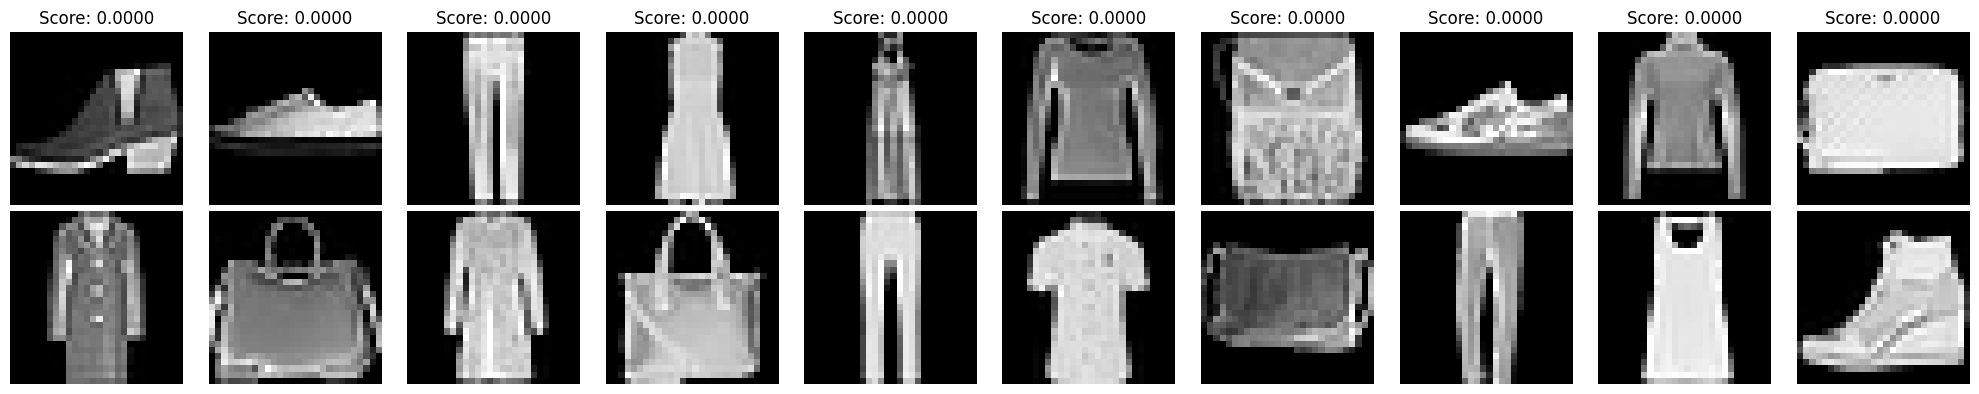


Quantized Representations and Decoded Images:


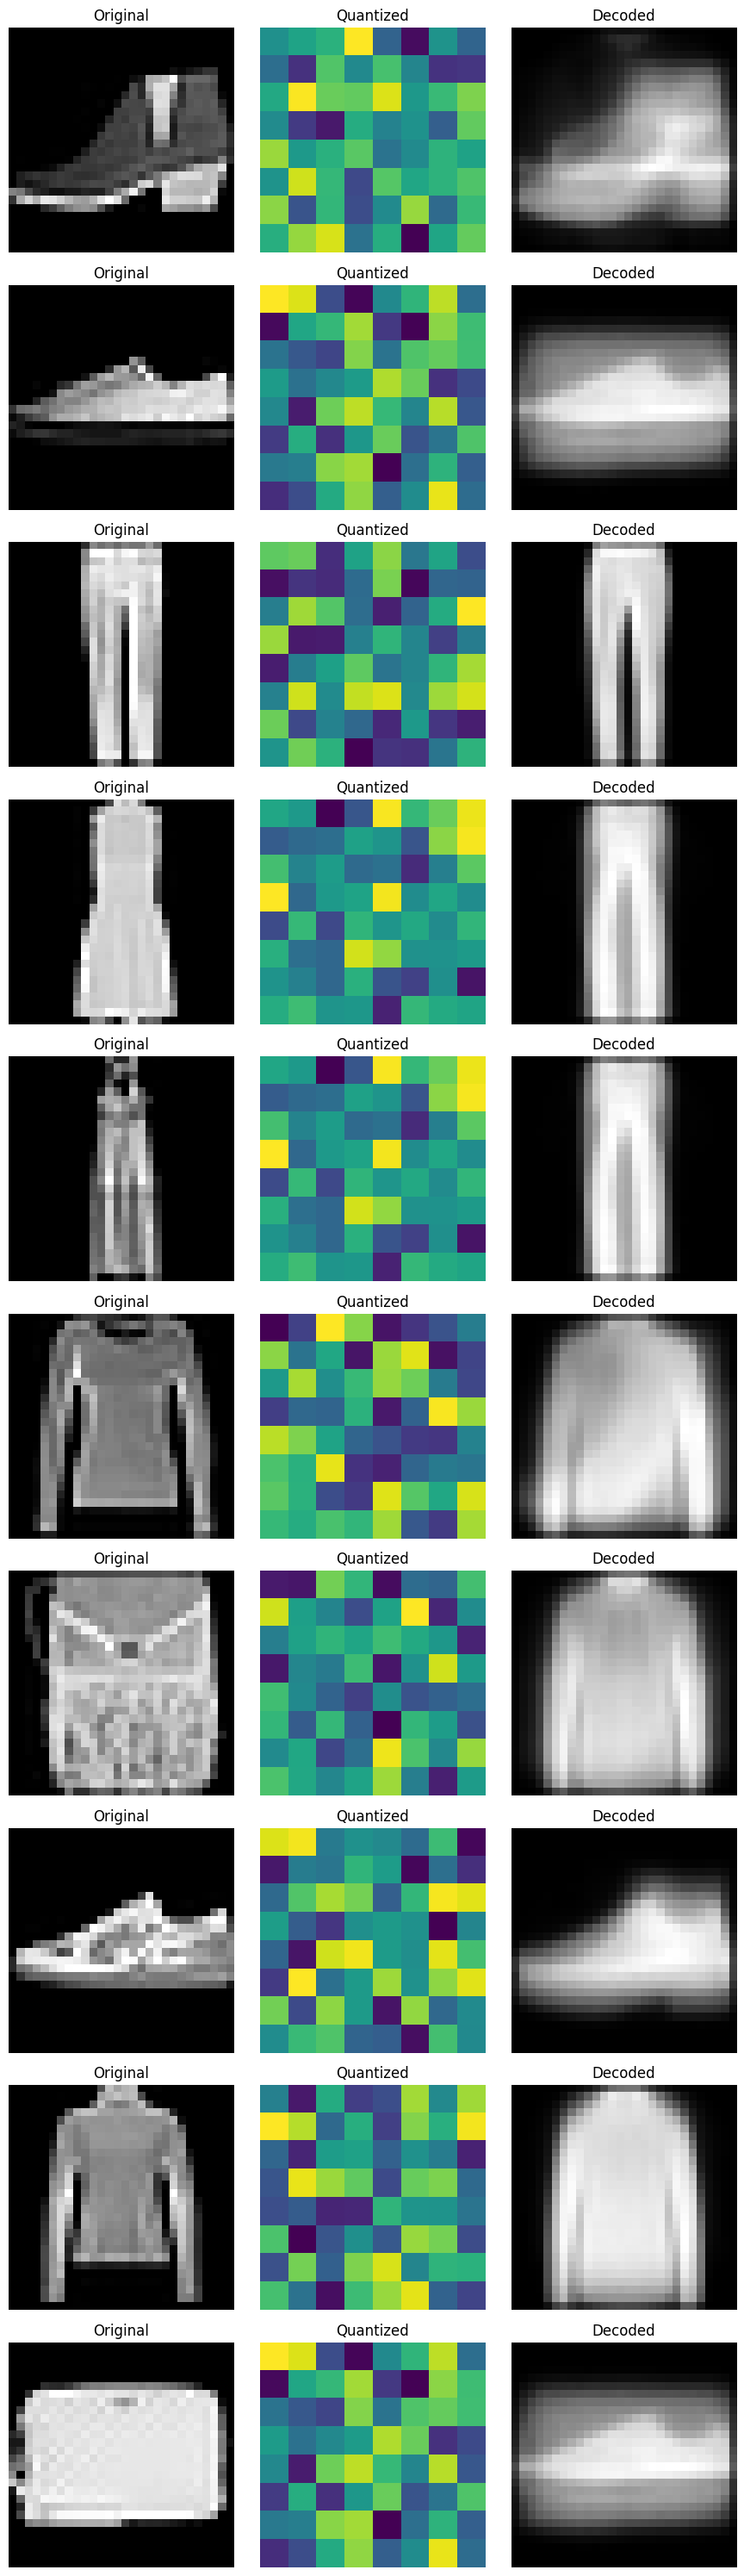

In [ ]:
# Choose a dataset (e.g., MNIST, Fashion-MNIST)
data, _ = datasets["Fashion-MNIST"]

# Pick a random image
idx, idx2  = np.random.randint(len(data)), np.random.randint(len(data))
test_images = data[idx:idx+10]
test_images_2 = data[idx2:idx2+10]


stacked_exact_pairs = torch.stack((test_images, test_images), dim=0)
stacked_different_pairs = torch.stack((test_images, test_images_2), dim=0)

#Test images described
z, quantized, _, _ = descriptor_model(test_images)

# Decode quantized representations
decoded_images = decoder_model(quantized)

#Quantized rep communicated and compared against original described images, and different images
exact_pair_scores = discriminator_model(quantized, test_images)
different_pair_scores = discriminator_model(quantized, test_images_2)

#Image pairs are displayed. Pairs (vertical) are labelled with the disriminator similarity score

print("Exact Pairs:")
visualize_tensor_grid(stacked_exact_pairs, exact_pair_scores)

print("\nDifferent Pairs:")
visualize_tensor_grid(stacked_different_pairs, different_pair_scores)


def visualize_quantized_and_decoded(original_images, quantized_reps, decoded_images):
    n_images = original_images.shape[0]
    fig, axs = plt.subplots(n_images, 3, figsize=(9, 3*n_images))

    for i in range(n_images):
        # Original image
        axs[i, 0].imshow(original_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axs[i, 0].set_title('Original')
        axs[i, 0].axis('off')

        # Quantized representation
        quantized_img = quantized_reps[i].cpu().detach().numpy()
        axs[i, 1].imshow(quantized_img.reshape(int(np.sqrt(quantized_img.shape[0])), -1), cmap='viridis')
        axs[i, 1].set_title('Quantized')
        axs[i, 1].axis('off')

        # Decoded image
        axs[i, 2].imshow(decoded_images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        axs[i, 2].set_title('Decoded')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

print("\nQuantized Representations and Decoded Images:")
visualize_quantized_and_decoded(test_images, quantized, decoded_images)


Implementation of Growing Codebook Size

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GrowableVectorQuantizer(nn.Module):
    def __init__(self, initial_num_embeddings, embedding_dim, commitment_cost=0.25):
        super(GrowableVectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Initialize the initial codebook as trainable
        self.trainable_embeddings = nn.Parameter(
            torch.FloatTensor(initial_num_embeddings, embedding_dim).uniform_(-1/initial_num_embeddings, 1/initial_num_embeddings)
        )

        # Initialize an empty tensor for frozen vectors
        self.register_buffer('frozen_embeddings', torch.empty(0, embedding_dim))

    @property
    def num_embeddings(self):
        return self.frozen_embeddings.size(0) + self.trainable_embeddings.size(0)

    def get_codebook(self):
        return torch.cat([self.frozen_embeddings, self.trainable_embeddings], dim=0)

    def get_trainable_codebook(self):
        return self.trainable_embeddings

    def grow_codebook(self, num_new_vectors):
        # Move current trainable embeddings to frozen
        current_frozen = self.frozen_embeddings
        new_frozen = torch.cat([current_frozen, self.trainable_embeddings.detach()], dim=0)
        self.register_buffer('frozen_embeddings', new_frozen)

        # Create new trainable embeddings
        new_embeddings = torch.empty(num_new_vectors, self.embedding_dim, device=self.trainable_embeddings.device)
        nn.init.uniform_(new_embeddings, -1/self.num_embeddings, 1/self.num_embeddings)
        self.trainable_embeddings = nn.Parameter(new_embeddings)

    def forward(self, inputs):
      if inputs.dim() == 1:
          inputs = inputs.unsqueeze(0)

      # Get the full codebook
      codebook = self.get_codebook()

      # Calculate distances
      distances = (torch.sum(inputs**2, dim=1, keepdim=True)
                  + torch.sum(codebook**2, dim=1)
                  - 2 * torch.matmul(inputs, codebook.t()))

      # Encoding
      encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
      encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
      encodings.scatter_(1, encoding_indices, 1)

      # Quantize
      quantized = torch.matmul(encodings, codebook)

      # Loss
      e_latent_loss = F.mse_loss(quantized.detach(), inputs)
      q_latent_loss = F.mse_loss(quantized, inputs.detach())
      loss = q_latent_loss + self.commitment_cost * e_latent_loss

      quantized = inputs + (quantized - inputs).detach()
      avg_probs = torch.mean(encodings, dim=0)
      perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

      return quantized, loss, perplexity, encodings



In [ ]:
class Growing_Descriptor(nn.Module):
    def __init__(self, input_dim, hidden_dim, initial_num_embeddings, embedding_dim):
        super(Growing_Descriptor, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

        # Vector Quantizer
        self.vq = GrowableVectorQuantizer(initial_num_embeddings, embedding_dim)


    def forward(self, x):
        # Get the full codebook
        codebook = self.vq.get_codebook() #Note to self: check how the codebook is actually used in fwd method: re frozen and active codes etc

        z = self.encoder(x)
        quantized, vq_loss, perplexity, _ = self.vq(z)

        return z, quantized, vq_loss, perplexity

    def get_codebook(self):
        return self.vq.get_codebook()

    def get_trainable_codebook(self):
        return self.vq.get_trainable_codebook()

    def print_codebook(self):
        print("Codebook:")
        print(self.vq.get_codebook())
        #print("Dimensionality: " + str(self.vq.get_codebook()[0].size(0)))

        return self.vq.get_codebook()

    def grow_codebook(self, num_new_vectors):
        extended_codebook = self.vq.grow_codebook(num_new_vectors)
        return extended_codebook

Training code which grows the codebook size after a fixed number of epochs
(TODO: other growth conditions e.g. loss stagnates)

NOTE: Non-trivial behaviour seems to require codebook sie > 30 ish - WHY? Was this bound also true above in the non-growing case?

Trivial Behaviour correpsonds to guessing ~0.5 for everything, and has associated loss of ~1.3

Analysing Trainable Codebook:
tensor([ 0.0848, -0.0579,  0.0986,  0.0014,  0.0594,  0.0285, -0.0050, -0.0123,
        -0.0851, -0.0878,  0.0102,  0.0592, -0.0255,  0.0685, -0.0881, -0.0980,
         0.0657, -0.0412,  0.0017,  0.0367,  0.0279,  0.0110,  0.0407,  0.0195,
         0.0130, -0.0393, -0.0234,  0.0447,  0.0908,  0.0523, -0.0350, -0.0847,
        -0.0350,  0.0184,  0.0383, -0.0166, -0.0010,  0.0684,  0.0478,  0.0920,
        -0.0687, -0.0998,  0.0205,  0.0581, -0.0325, -0.0859, -0.0385, -0.0737,
         0.0733, -0.0383,  0.0212, -0.0386,  0.0993, -0.0614,  0.0594, -0.0268,
         0.0868, -0.0547, -0.0457, -0.0016, -0.0609,  0.0779, -0.0065, -0.0860],
       requires_grad=True)
tensor([-0.0286,  0.0100, -0.0223, -0.0240, -0.0102, -0.0900, -0.0994, -0.0950,
         0.0581,  0.0995,  0.0512,  0.0878,  0.0611,  0.0603, -0.0154, -0.0692,
        -0.0275, -0.0013, -0.0460, -0.0439,  0.0571,  0.0553, -0.0249,  0.0466,
        -0.0949, -0.0588, -0.0012, -0.0761,  0.0495,  0.0758, 

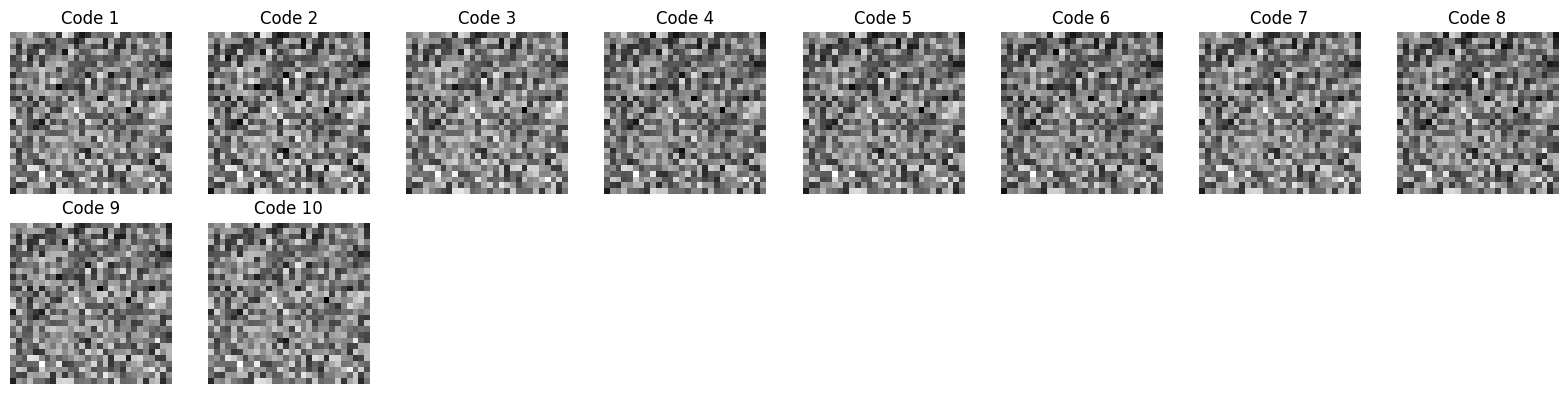

Epoch [1/500], Desc/Disc Loss: 8.8198, Decoder Loss: 0.0846
Epoch [2/500], Desc/Disc Loss: 3.7226, Decoder Loss: 0.0709
Epoch [3/500], Desc/Disc Loss: 8.4826, Decoder Loss: 0.0672
Epoch [4/500], Desc/Disc Loss: 4.6290, Decoder Loss: 0.0677
Epoch [5/500], Desc/Disc Loss: 3.1290, Decoder Loss: 0.0682
Epoch [6/500], Desc/Disc Loss: 7.0079, Decoder Loss: 0.0669
Epoch [7/500], Desc/Disc Loss: 3.2121, Decoder Loss: 0.0713
Epoch [8/500], Desc/Disc Loss: 4.7181, Decoder Loss: 0.0656
Epoch [9/500], Desc/Disc Loss: 4.1038, Decoder Loss: 0.0643
Epoch [10/500], Desc/Disc Loss: 3.5324, Decoder Loss: 0.0639
Analysing Trainable Codebook:
tensor([ 0.1948, -0.2232,  0.2329, -0.1320,  0.2104, -0.0783,  0.2212,  0.1409,
         0.0490,  0.1454,  0.1641, -0.0750, -0.1543, -0.0069,  0.1109, -0.2272,
        -0.0612,  0.1354,  0.1604,  0.1645,  0.2022, -0.1404, -0.1215,  0.1221,
        -0.1910,  0.1296, -0.1797,  0.2523, -0.0073, -0.1436, -0.2267, -0.1712,
         0.1158, -0.2031, -0.1869, -0.1939, -0.14

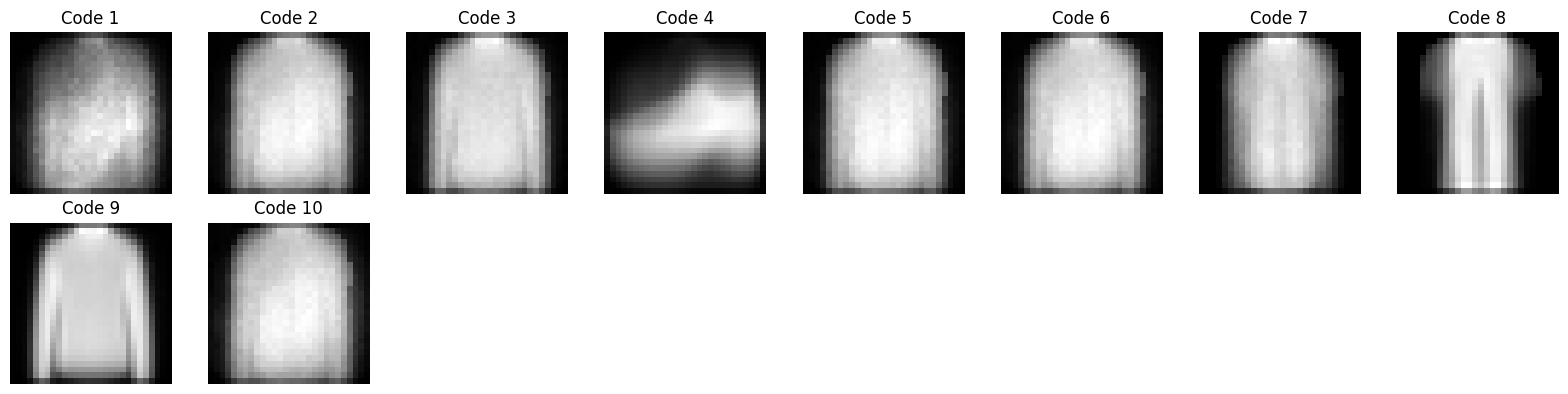

Epoch [11/500], Desc/Disc Loss: 5.0928, Decoder Loss: 0.0630
Epoch [12/500], Desc/Disc Loss: 2.9155, Decoder Loss: 0.0602
Epoch [13/500], Desc/Disc Loss: 3.3769, Decoder Loss: 0.0600
Epoch [14/500], Desc/Disc Loss: 2.5952, Decoder Loss: 0.0599
Epoch [15/500], Desc/Disc Loss: 2.2617, Decoder Loss: 0.0599
Epoch [16/500], Desc/Disc Loss: 2.7260, Decoder Loss: 0.0598
Epoch [17/500], Desc/Disc Loss: 3.2386, Decoder Loss: 0.0589
Epoch [18/500], Desc/Disc Loss: 3.0719, Decoder Loss: 0.0565
Epoch [19/500], Desc/Disc Loss: 2.8244, Decoder Loss: 0.0617
Epoch [20/500], Desc/Disc Loss: 3.0327, Decoder Loss: 0.0618
Analysing Trainable Codebook:
tensor([-0.0092, -0.4692,  0.4478, -0.4022,  0.4530, -0.2656,  0.4605,  0.3990,
         0.2725,  0.3239,  0.4092, -0.3288, -0.4123, -0.2034,  0.3547, -0.4466,
        -0.2542,  0.4018,  0.4009,  0.4102,  0.4229, -0.4130, -0.3571,  0.3672,
        -0.4386,  0.3760, -0.4122,  0.4971, -0.2058, -0.4023, -0.2148, -0.3549,
         0.3309, -0.4107, -0.4274, -0.41

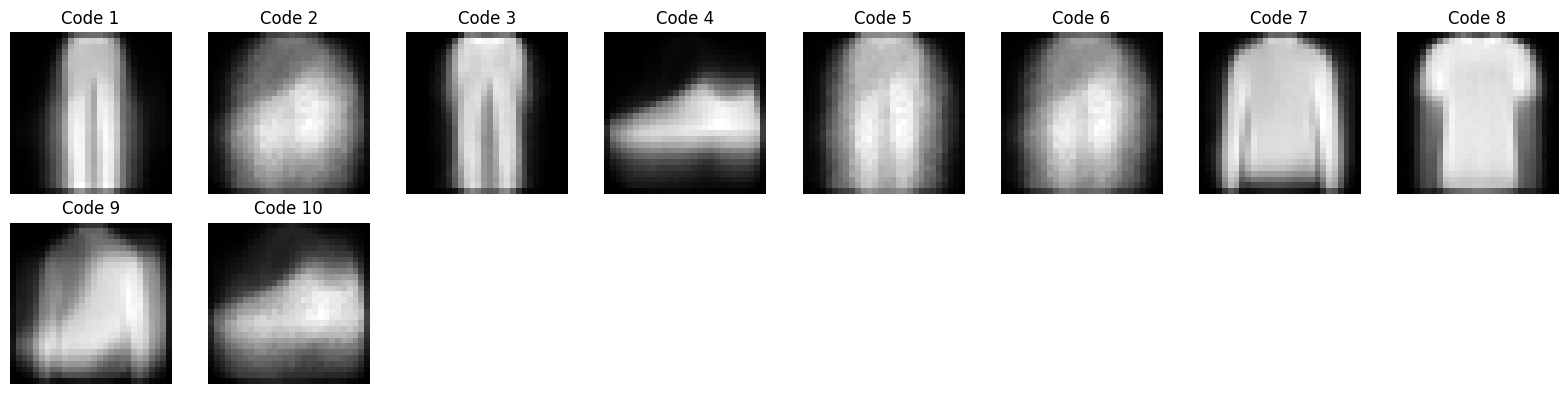

Epoch [21/500], Desc/Disc Loss: 2.6339, Decoder Loss: 0.0632
Epoch [22/500], Desc/Disc Loss: 2.9174, Decoder Loss: 0.0611
Epoch [23/500], Desc/Disc Loss: 2.5617, Decoder Loss: 0.0603
Epoch [24/500], Desc/Disc Loss: 2.5844, Decoder Loss: 0.0598
Epoch [25/500], Desc/Disc Loss: 2.5193, Decoder Loss: 0.0606
Epoch [26/500], Desc/Disc Loss: 2.3056, Decoder Loss: 0.0598
Epoch [27/500], Desc/Disc Loss: 2.1304, Decoder Loss: 0.0609
Epoch [28/500], Desc/Disc Loss: 1.8686, Decoder Loss: 0.0602
Epoch [29/500], Desc/Disc Loss: 1.9312, Decoder Loss: 0.0613
Epoch [30/500], Desc/Disc Loss: 1.6447, Decoder Loss: 0.0607
Analysing Trainable Codebook:
tensor([ 0.0402, -0.7344,  0.6782, -0.6588,  0.6903, -0.3796,  0.6938,  0.6279,
         0.4448,  0.5437,  0.6746, -0.5349, -0.6183, -0.3329,  0.6182, -0.7075,
        -0.4142,  0.6675,  0.6419,  0.6245,  0.6773, -0.6563, -0.5507,  0.5936,
        -0.6939,  0.5705, -0.6352,  0.7475, -0.3273, -0.6512, -0.4339, -0.6088,
         0.3691, -0.6561, -0.6636, -0.62

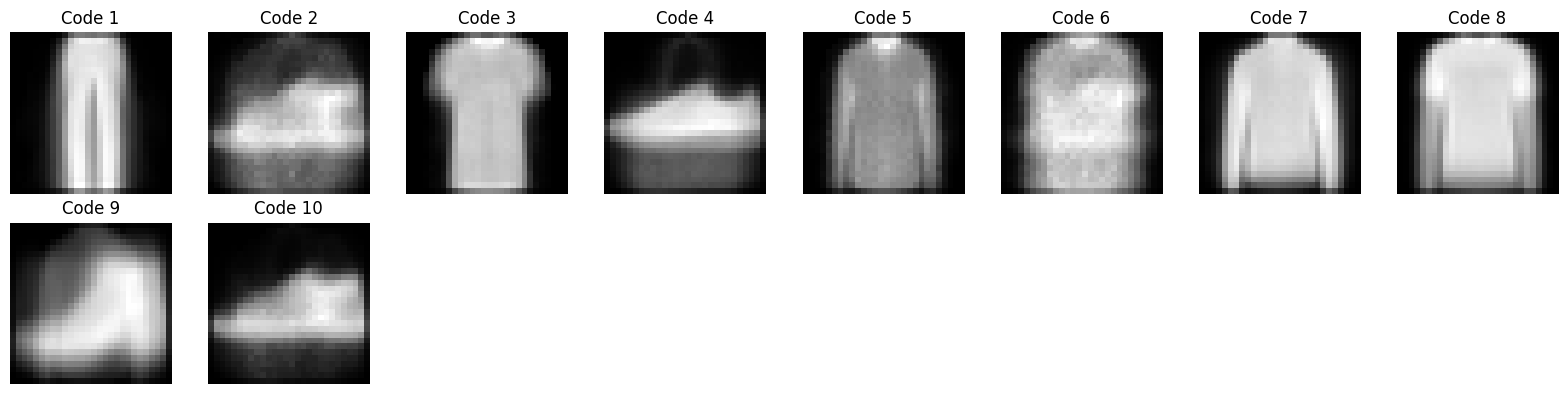

Epoch [31/500], Desc/Disc Loss: 1.7722, Decoder Loss: 0.0620
Epoch [32/500], Desc/Disc Loss: 1.5043, Decoder Loss: 0.0613
Epoch [33/500], Desc/Disc Loss: 1.7457, Decoder Loss: 0.0603
Epoch [34/500], Desc/Disc Loss: 1.4723, Decoder Loss: 0.0606
Epoch [35/500], Desc/Disc Loss: 1.4647, Decoder Loss: 0.0613
Epoch [36/500], Desc/Disc Loss: 1.4556, Decoder Loss: 0.0589
Epoch [37/500], Desc/Disc Loss: 1.5657, Decoder Loss: 0.0577
Epoch [38/500], Desc/Disc Loss: 1.3599, Decoder Loss: 0.0585
Epoch [39/500], Desc/Disc Loss: 1.5421, Decoder Loss: 0.0570
Epoch [40/500], Desc/Disc Loss: 1.3066, Decoder Loss: 0.0549
Analysing Trainable Codebook:
tensor([-0.2019, -0.9384,  0.6186, -0.8683,  0.8694, -0.3600,  0.8619,  0.8041,
         0.6501,  0.3637,  0.8601, -0.7037, -0.7810, -0.4184,  0.7854, -0.8026,
        -0.4999,  0.8719,  0.8167,  0.7690,  0.8418, -0.8489, -0.5598,  0.7500,
        -0.9098,  0.4089, -0.5541,  0.9489, -0.6088, -0.8775, -0.3823, -0.7756,
         0.2615, -0.7515, -0.7683, -0.47

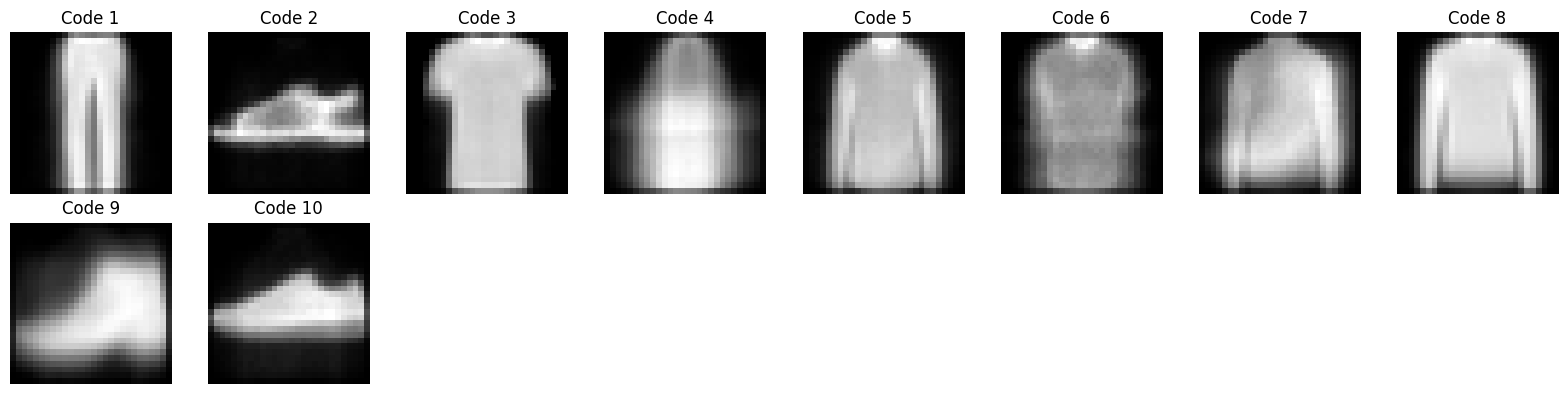

Epoch [41/500], Desc/Disc Loss: 1.3057, Decoder Loss: 0.0560
Epoch [42/500], Desc/Disc Loss: 1.2567, Decoder Loss: 0.0575
Epoch [43/500], Desc/Disc Loss: 1.3224, Decoder Loss: 0.0567
Epoch [44/500], Desc/Disc Loss: 1.2712, Decoder Loss: 0.0555
Epoch [45/500], Desc/Disc Loss: 1.1636, Decoder Loss: 0.0596
Epoch [46/500], Desc/Disc Loss: 1.1427, Decoder Loss: 0.0591
Epoch [47/500], Desc/Disc Loss: 1.3595, Decoder Loss: 0.0589
Epoch [48/500], Desc/Disc Loss: 1.2601, Decoder Loss: 0.0578
Epoch [49/500], Desc/Disc Loss: 1.3834, Decoder Loss: 0.0585
Epoch [50/500], Desc/Disc Loss: 1.0614, Decoder Loss: 0.0580
Analysing Trainable Codebook:
tensor([-0.3912, -1.0816,  0.4154, -1.0485,  0.9810, -0.1184,  0.9249,  0.9545,
         0.7017,  0.1414,  0.9545, -0.8422, -0.9386, -0.2310,  0.7793, -0.6727,
        -0.3059,  0.9864,  0.9311,  0.7852,  0.8895, -1.0119, -0.3898,  0.7905,
        -1.0694,  0.1937, -0.3400,  1.1010, -0.7712, -1.0459, -0.2135, -0.9291,
         0.1006, -0.6669, -0.7112, -0.24

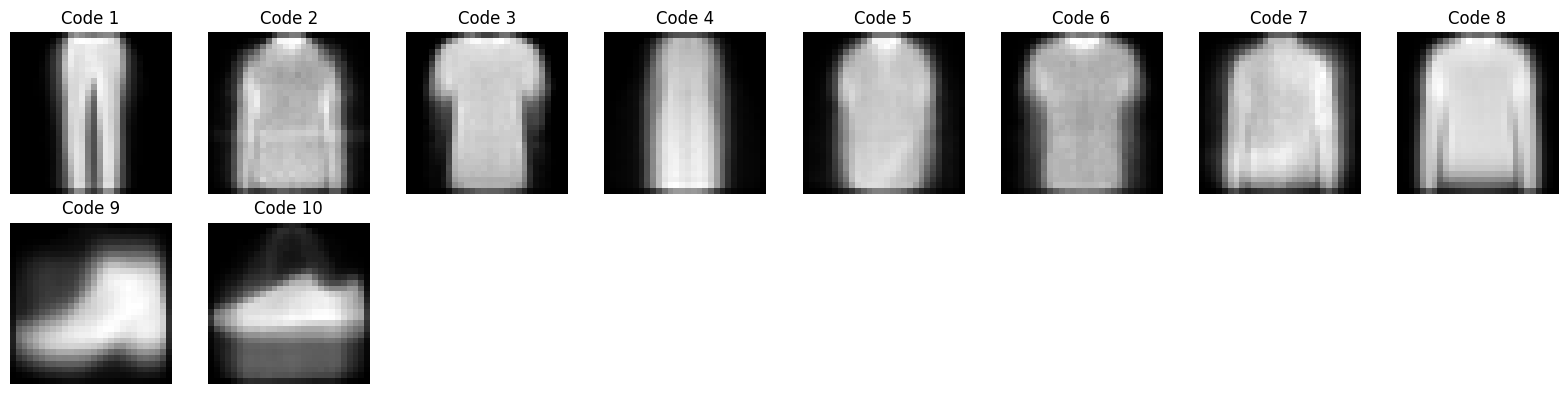


New codebook size: 11
Trainable: encoder.0.weight, Shape: torch.Size([256, 784])
Trainable: encoder.0.bias, Shape: torch.Size([256])
Trainable: encoder.2.weight, Shape: torch.Size([64, 256])
Trainable: encoder.2.bias, Shape: torch.Size([64])
Trainable: vq.trainable_embeddings, Shape: torch.Size([1, 64])


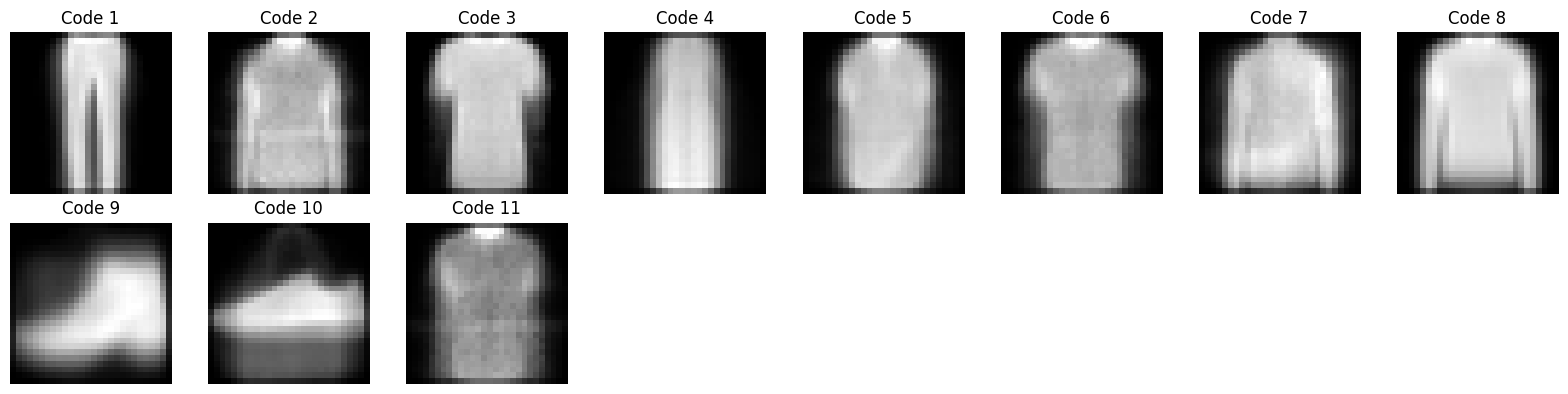

Epoch [51/500], Desc/Disc Loss: 1.1206, Decoder Loss: 0.0574
Epoch [52/500], Desc/Disc Loss: 1.1833, Decoder Loss: 0.0585
Epoch [53/500], Desc/Disc Loss: 1.0672, Decoder Loss: 0.0572
Epoch [54/500], Desc/Disc Loss: 1.1865, Decoder Loss: 0.0573
Epoch [55/500], Desc/Disc Loss: 1.2038, Decoder Loss: 0.0574
Epoch [56/500], Desc/Disc Loss: 1.2514, Decoder Loss: 0.0579
Epoch [57/500], Desc/Disc Loss: 1.3022, Decoder Loss: 0.0575
Epoch [58/500], Desc/Disc Loss: 1.1266, Decoder Loss: 0.0578
Epoch [59/500], Desc/Disc Loss: 1.1539, Decoder Loss: 0.0575
Epoch [60/500], Desc/Disc Loss: 1.1640, Decoder Loss: 0.0578
Analysing Trainable Codebook:
tensor([ 4.5962e-02, -2.6933e-02, -3.6850e-02,  4.1288e-05, -2.0083e-02,
        -2.7851e-02,  1.8562e-02,  4.7531e-02,  2.3689e-02, -2.4046e-02,
        -2.1610e-02, -4.0680e-02, -4.8252e-02, -3.6481e-02, -4.0351e-02,
         8.0155e-03,  4.8351e-03, -1.2789e-02,  1.2152e-02,  1.1670e-02,
        -2.2991e-02,  1.5299e-02,  4.0862e-02, -3.5108e-02,  3.7317e

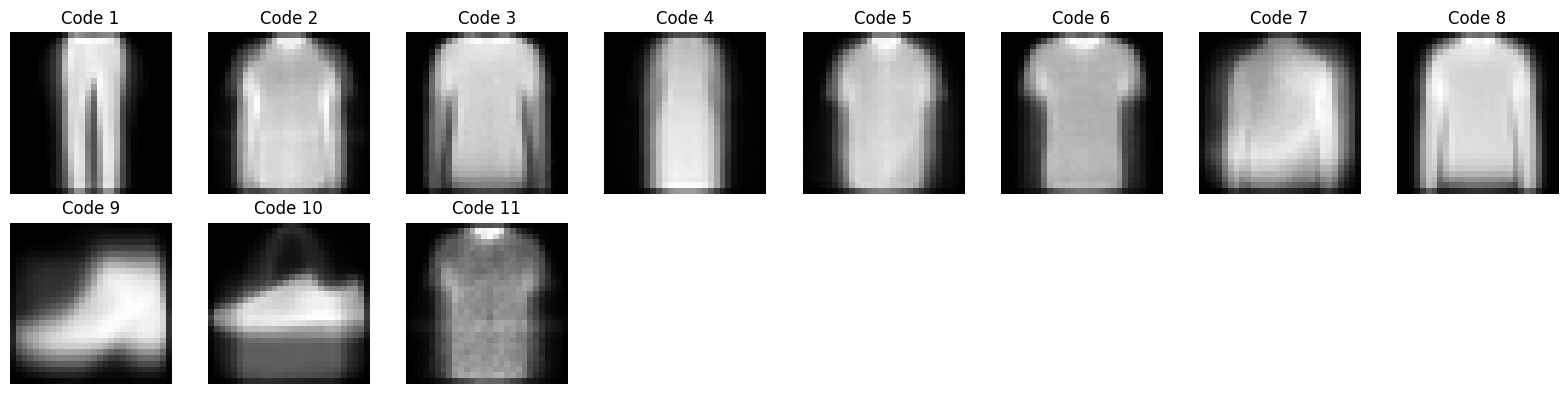

Epoch [61/500], Desc/Disc Loss: 1.2152, Decoder Loss: 0.0580
Epoch [62/500], Desc/Disc Loss: 1.3292, Decoder Loss: 0.0580
Epoch [63/500], Desc/Disc Loss: 1.0766, Decoder Loss: 0.0570
Epoch [64/500], Desc/Disc Loss: 1.2810, Decoder Loss: 0.0576
Epoch [65/500], Desc/Disc Loss: 1.0998, Decoder Loss: 0.0554
Epoch [66/500], Desc/Disc Loss: 1.1128, Decoder Loss: 0.0564
Epoch [67/500], Desc/Disc Loss: 1.1297, Decoder Loss: 0.0567
Epoch [68/500], Desc/Disc Loss: 0.9904, Decoder Loss: 0.0560
Epoch [69/500], Desc/Disc Loss: 1.1424, Decoder Loss: 0.0557
Epoch [70/500], Desc/Disc Loss: 1.2313, Decoder Loss: 0.0573
Analysing Trainable Codebook:
tensor([ 4.5962e-02, -2.6933e-02, -3.6850e-02,  4.1288e-05, -2.0083e-02,
        -2.7851e-02,  1.8562e-02,  4.7531e-02,  2.3689e-02, -2.4046e-02,
        -2.1610e-02, -4.0680e-02, -4.8252e-02, -3.6481e-02, -4.0351e-02,
         8.0155e-03,  4.8351e-03, -1.2789e-02,  1.2152e-02,  1.1670e-02,
        -2.2991e-02,  1.5299e-02,  4.0862e-02, -3.5108e-02,  3.7317e

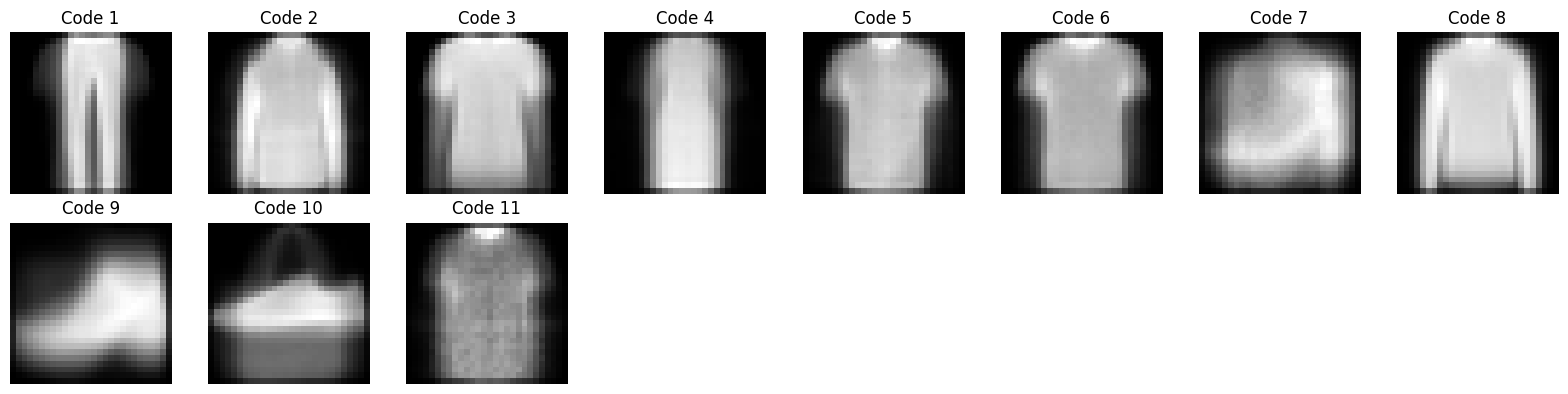

Epoch [71/500], Desc/Disc Loss: 0.9995, Decoder Loss: 0.0563
Epoch [72/500], Desc/Disc Loss: 1.1020, Decoder Loss: 0.0575
Epoch [73/500], Desc/Disc Loss: 1.1469, Decoder Loss: 0.0565
Epoch [74/500], Desc/Disc Loss: 1.0738, Decoder Loss: 0.0562
Epoch [75/500], Desc/Disc Loss: 1.0242, Decoder Loss: 0.0559
Epoch [76/500], Desc/Disc Loss: 1.1149, Decoder Loss: 0.0562
Epoch [77/500], Desc/Disc Loss: 1.2223, Decoder Loss: 0.0559
Epoch [78/500], Desc/Disc Loss: 1.0888, Decoder Loss: 0.0555
Epoch [79/500], Desc/Disc Loss: 1.2419, Decoder Loss: 0.0552
Epoch [80/500], Desc/Disc Loss: 1.1643, Decoder Loss: 0.0546
Analysing Trainable Codebook:
tensor([ 4.5962e-02, -2.6933e-02, -3.6850e-02,  4.1288e-05, -2.0083e-02,
        -2.7851e-02,  1.8562e-02,  4.7531e-02,  2.3689e-02, -2.4046e-02,
        -2.1610e-02, -4.0680e-02, -4.8252e-02, -3.6481e-02, -4.0351e-02,
         8.0155e-03,  4.8351e-03, -1.2789e-02,  1.2152e-02,  1.1670e-02,
        -2.2991e-02,  1.5299e-02,  4.0862e-02, -3.5108e-02,  3.7317e

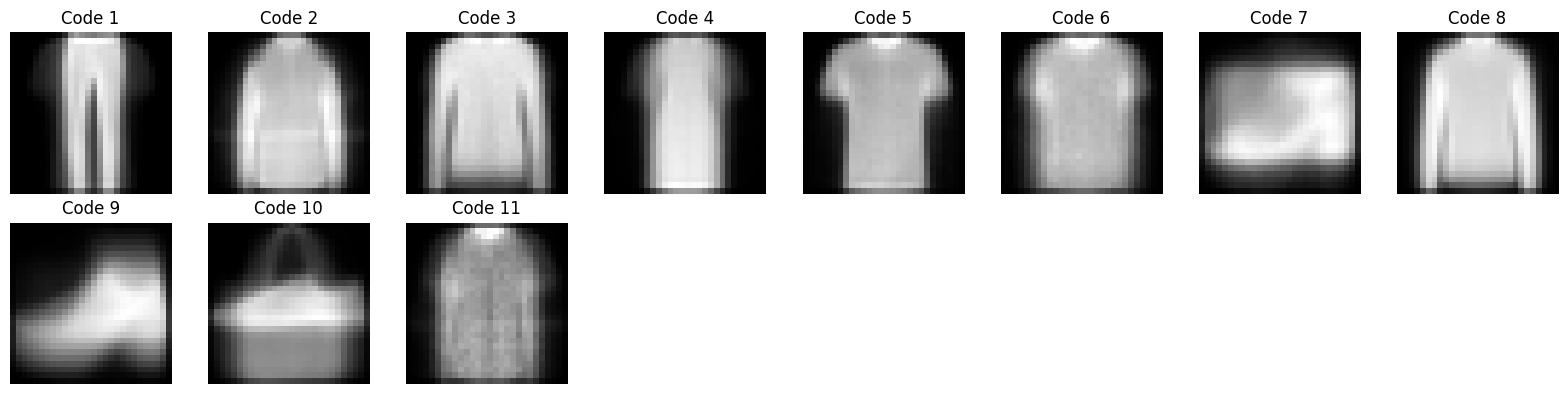

Epoch [81/500], Desc/Disc Loss: 1.0967, Decoder Loss: 0.0559
Epoch [82/500], Desc/Disc Loss: 1.0909, Decoder Loss: 0.0533
Epoch [83/500], Desc/Disc Loss: 1.0666, Decoder Loss: 0.0547
Epoch [84/500], Desc/Disc Loss: 1.1501, Decoder Loss: 0.0539
Epoch [85/500], Desc/Disc Loss: 1.0699, Decoder Loss: 0.0559
Epoch [86/500], Desc/Disc Loss: 0.8532, Decoder Loss: 0.0542
Epoch [87/500], Desc/Disc Loss: 1.1097, Decoder Loss: 0.0564
Epoch [88/500], Desc/Disc Loss: 1.0865, Decoder Loss: 0.0562
Epoch [89/500], Desc/Disc Loss: 1.1467, Decoder Loss: 0.0567
Epoch [90/500], Desc/Disc Loss: 1.2051, Decoder Loss: 0.0569
Analysing Trainable Codebook:
tensor([ 4.5962e-02, -2.6933e-02, -3.6850e-02,  4.1288e-05, -2.0083e-02,
        -2.7851e-02,  1.8562e-02,  4.7531e-02,  2.3689e-02, -2.4046e-02,
        -2.1610e-02, -4.0680e-02, -4.8252e-02, -3.6481e-02, -4.0351e-02,
         8.0155e-03,  4.8351e-03, -1.2789e-02,  1.2152e-02,  1.1670e-02,
        -2.2991e-02,  1.5299e-02,  4.0862e-02, -3.5108e-02,  3.7317e

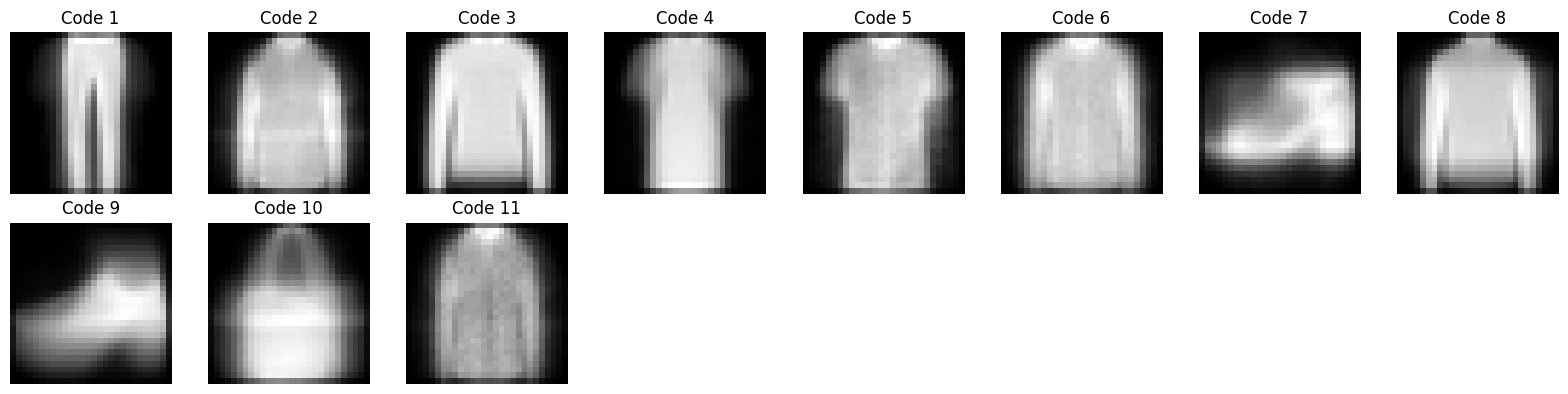

Epoch [91/500], Desc/Disc Loss: 1.2277, Decoder Loss: 0.0574
Epoch [92/500], Desc/Disc Loss: 1.0291, Decoder Loss: 0.0565
Epoch [93/500], Desc/Disc Loss: 1.2885, Decoder Loss: 0.0573
Epoch [94/500], Desc/Disc Loss: 1.2546, Decoder Loss: 0.0571
Epoch [95/500], Desc/Disc Loss: 1.1800, Decoder Loss: 0.0572
Epoch [96/500], Desc/Disc Loss: 1.1767, Decoder Loss: 0.0581
Epoch [97/500], Desc/Disc Loss: 1.1246, Decoder Loss: 0.0589
Epoch [98/500], Desc/Disc Loss: 1.3973, Decoder Loss: 0.0584
Epoch [99/500], Desc/Disc Loss: 1.3352, Decoder Loss: 0.0581
Epoch [100/500], Desc/Disc Loss: 1.4405, Decoder Loss: 0.0582
Analysing Trainable Codebook:
tensor([ 4.5962e-02, -2.6933e-02, -3.6850e-02,  4.1288e-05, -2.0083e-02,
        -2.7851e-02,  1.8562e-02,  4.7531e-02,  2.3689e-02, -2.4046e-02,
        -2.1610e-02, -4.0680e-02, -4.8252e-02, -3.6481e-02, -4.0351e-02,
         8.0155e-03,  4.8351e-03, -1.2789e-02,  1.2152e-02,  1.1670e-02,
        -2.2991e-02,  1.5299e-02,  4.0862e-02, -3.5108e-02,  3.7317

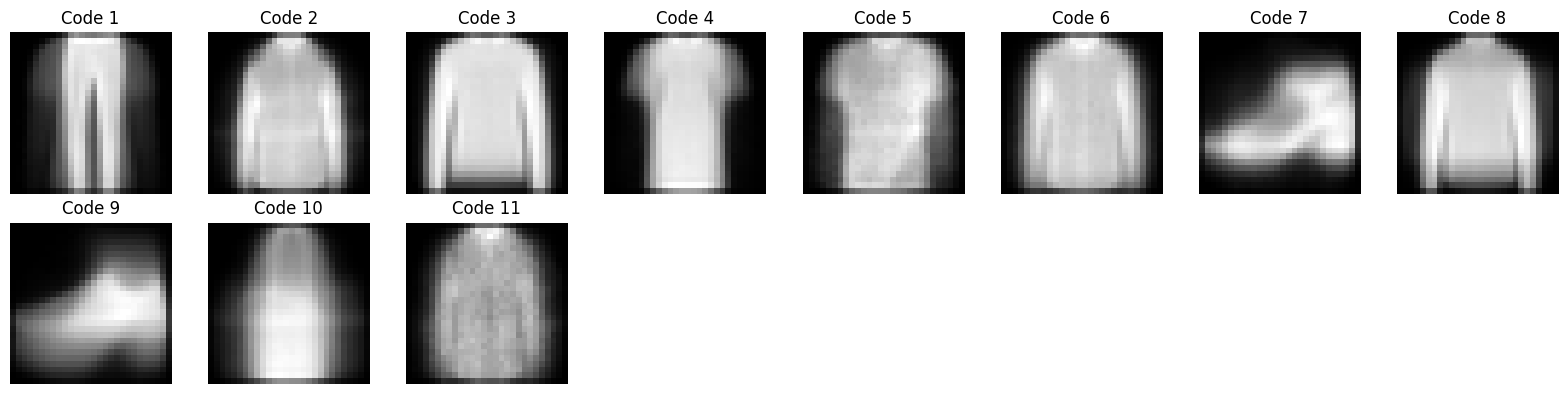


New codebook size: 12
Trainable: encoder.0.weight, Shape: torch.Size([256, 784])
Trainable: encoder.0.bias, Shape: torch.Size([256])
Trainable: encoder.2.weight, Shape: torch.Size([64, 256])
Trainable: encoder.2.bias, Shape: torch.Size([64])
Trainable: vq.trainable_embeddings, Shape: torch.Size([1, 64])


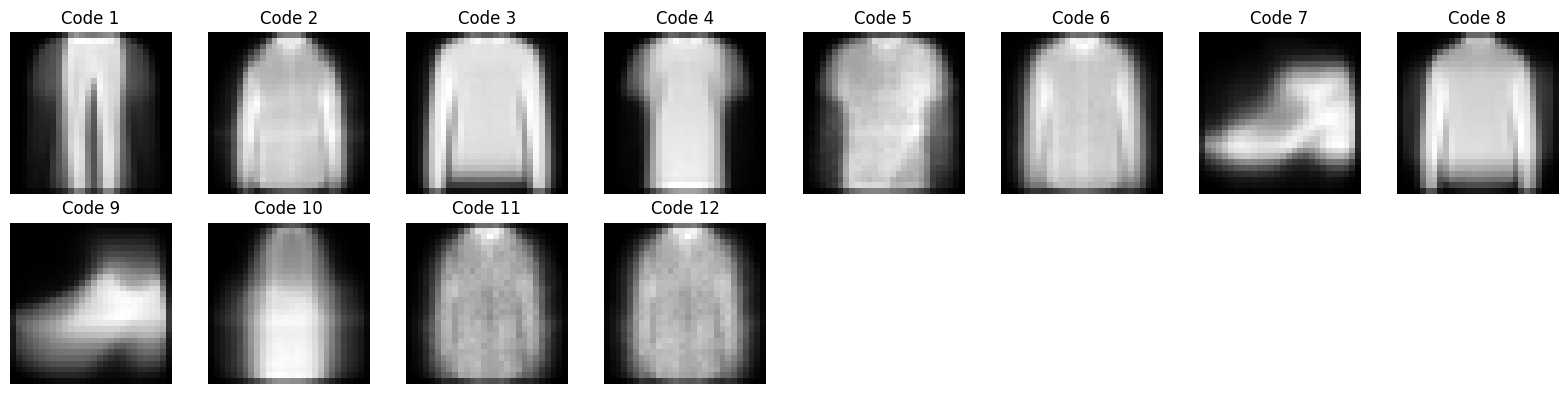

Epoch [101/500], Desc/Disc Loss: 1.3604, Decoder Loss: 0.0598
Epoch [102/500], Desc/Disc Loss: 1.3938, Decoder Loss: 0.0593
Epoch [103/500], Desc/Disc Loss: 1.2127, Decoder Loss: 0.0593
Epoch [104/500], Desc/Disc Loss: 1.4252, Decoder Loss: 0.0599
Epoch [105/500], Desc/Disc Loss: 1.4139, Decoder Loss: 0.0599
Epoch [106/500], Desc/Disc Loss: 1.3434, Decoder Loss: 0.0601
Epoch [107/500], Desc/Disc Loss: 1.4878, Decoder Loss: 0.0596
Epoch [108/500], Desc/Disc Loss: 1.3094, Decoder Loss: 0.0593
Epoch [109/500], Desc/Disc Loss: 1.2683, Decoder Loss: 0.0591
Epoch [110/500], Desc/Disc Loss: 1.3007, Decoder Loss: 0.0591
Analysing Trainable Codebook:
tensor([-0.0823,  0.0140, -0.0704, -0.0239, -0.0300, -0.0043, -0.0337, -0.0217,
         0.0582,  0.0710,  0.0230, -0.0255,  0.0290,  0.0295,  0.0517, -0.0498,
         0.0211, -0.0520,  0.0450, -0.0773, -0.0525,  0.0593,  0.0816,  0.0007,
        -0.0480, -0.0562, -0.0181, -0.0201, -0.0236, -0.0762,  0.0279,  0.0821,
         0.0040,  0.0113, -0.0

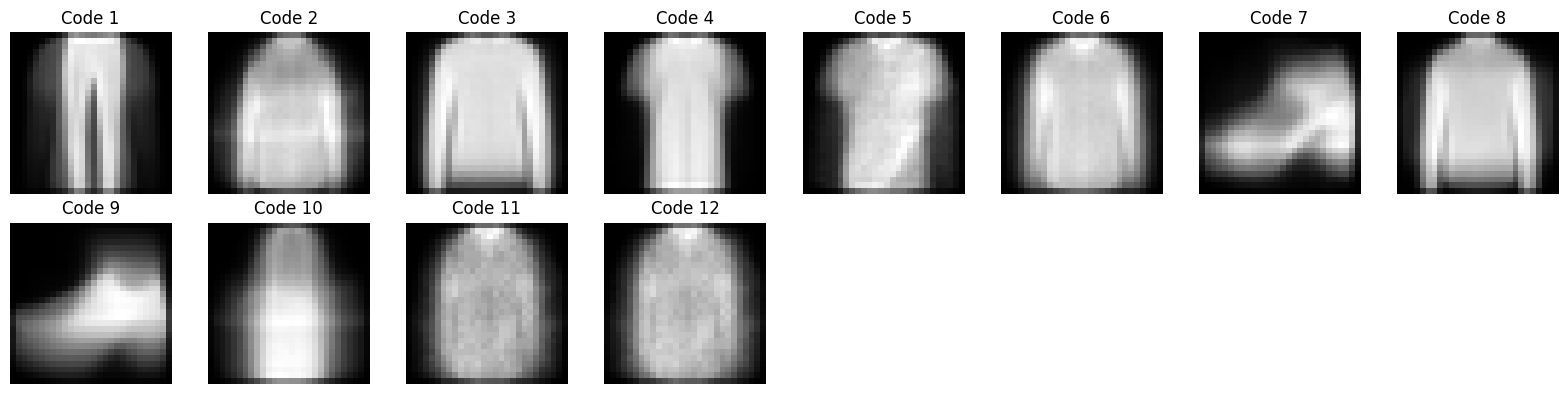

Epoch [111/500], Desc/Disc Loss: 1.2733, Decoder Loss: 0.0595
Epoch [112/500], Desc/Disc Loss: 1.1968, Decoder Loss: 0.0595
Epoch [113/500], Desc/Disc Loss: 1.3787, Decoder Loss: 0.0596
Epoch [114/500], Desc/Disc Loss: 1.3848, Decoder Loss: 0.0583
Epoch [115/500], Desc/Disc Loss: 1.3732, Decoder Loss: 0.0586
Epoch [116/500], Desc/Disc Loss: 1.2728, Decoder Loss: 0.0588
Epoch [117/500], Desc/Disc Loss: 1.3279, Decoder Loss: 0.0595
Epoch [118/500], Desc/Disc Loss: 1.3600, Decoder Loss: 0.0599
Epoch [119/500], Desc/Disc Loss: 1.3952, Decoder Loss: 0.0593
Epoch [120/500], Desc/Disc Loss: 1.3192, Decoder Loss: 0.0598
Analysing Trainable Codebook:
tensor([-0.0823,  0.0140, -0.0704, -0.0239, -0.0300, -0.0043, -0.0337, -0.0217,
         0.0582,  0.0710,  0.0230, -0.0255,  0.0290,  0.0295,  0.0517, -0.0498,
         0.0211, -0.0520,  0.0450, -0.0773, -0.0525,  0.0593,  0.0816,  0.0007,
        -0.0480, -0.0562, -0.0181, -0.0201, -0.0236, -0.0762,  0.0279,  0.0821,
         0.0040,  0.0113, -0.0

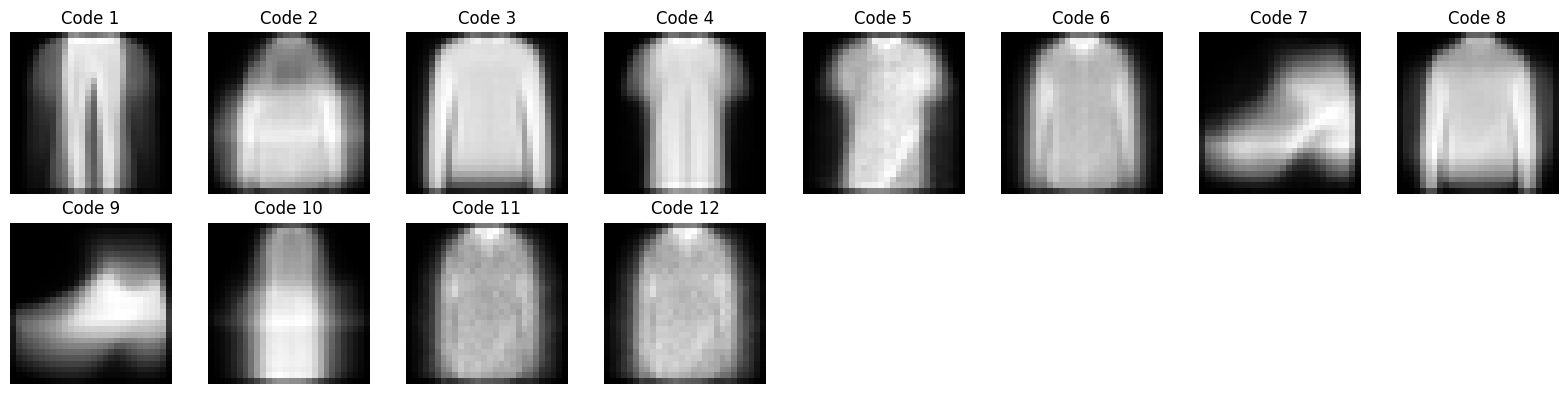

Epoch [121/500], Desc/Disc Loss: 1.3854, Decoder Loss: 0.0605
Epoch [122/500], Desc/Disc Loss: 1.4066, Decoder Loss: 0.0602
Epoch [123/500], Desc/Disc Loss: 1.3669, Decoder Loss: 0.0607
Epoch [124/500], Desc/Disc Loss: 1.3446, Decoder Loss: 0.0612
Epoch [125/500], Desc/Disc Loss: 1.2782, Decoder Loss: 0.0610
Epoch [126/500], Desc/Disc Loss: 1.4431, Decoder Loss: 0.0608
Epoch [127/500], Desc/Disc Loss: 1.4160, Decoder Loss: 0.0615
Epoch [128/500], Desc/Disc Loss: 1.5846, Decoder Loss: 0.0612
Epoch [129/500], Desc/Disc Loss: 1.5376, Decoder Loss: 0.0611
Epoch [130/500], Desc/Disc Loss: 1.4790, Decoder Loss: 0.0616
Analysing Trainable Codebook:
tensor([-0.0823,  0.0140, -0.0704, -0.0239, -0.0300, -0.0043, -0.0337, -0.0217,
         0.0582,  0.0710,  0.0230, -0.0255,  0.0290,  0.0295,  0.0517, -0.0498,
         0.0211, -0.0520,  0.0450, -0.0773, -0.0525,  0.0593,  0.0816,  0.0007,
        -0.0480, -0.0562, -0.0181, -0.0201, -0.0236, -0.0762,  0.0279,  0.0821,
         0.0040,  0.0113, -0.0

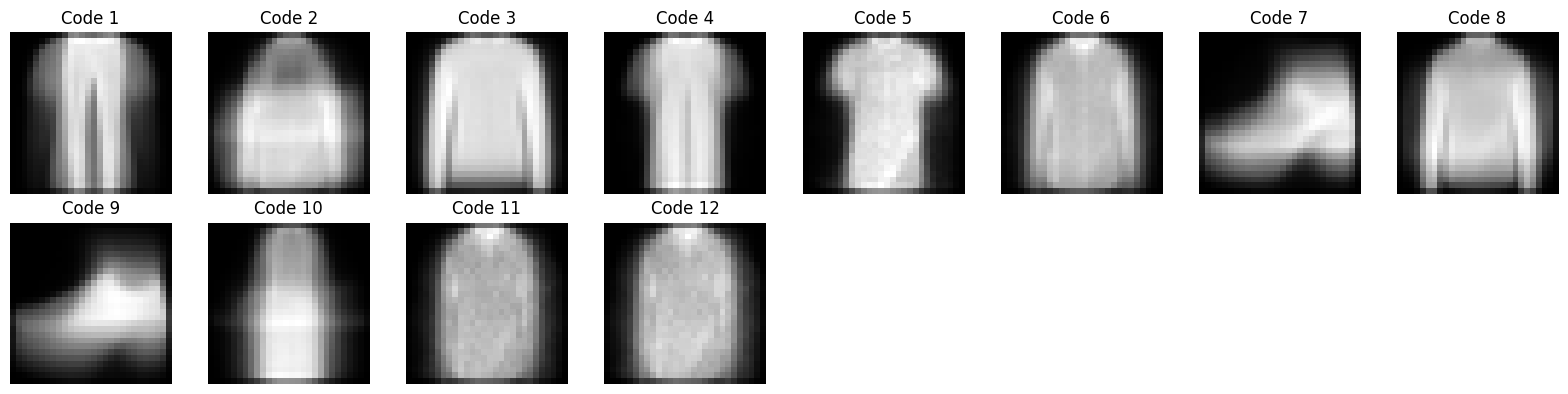

Epoch [131/500], Desc/Disc Loss: 1.3014, Decoder Loss: 0.0619
Epoch [132/500], Desc/Disc Loss: 1.2357, Decoder Loss: 0.0625
Epoch [133/500], Desc/Disc Loss: 1.2796, Decoder Loss: 0.0615
Epoch [134/500], Desc/Disc Loss: 1.2041, Decoder Loss: 0.0610
Epoch [135/500], Desc/Disc Loss: 1.1948, Decoder Loss: 0.0606
Epoch [136/500], Desc/Disc Loss: 1.1696, Decoder Loss: 0.0615
Epoch [137/500], Desc/Disc Loss: 1.2465, Decoder Loss: 0.0615
Epoch [138/500], Desc/Disc Loss: 1.3564, Decoder Loss: 0.0614
Epoch [139/500], Desc/Disc Loss: 1.2907, Decoder Loss: 0.0616
Epoch [140/500], Desc/Disc Loss: 1.2827, Decoder Loss: 0.0609
Analysing Trainable Codebook:
tensor([-0.0823,  0.0140, -0.0704, -0.0239, -0.0300, -0.0043, -0.0337, -0.0217,
         0.0582,  0.0710,  0.0230, -0.0255,  0.0290,  0.0295,  0.0517, -0.0498,
         0.0211, -0.0520,  0.0450, -0.0773, -0.0525,  0.0593,  0.0816,  0.0007,
        -0.0480, -0.0562, -0.0181, -0.0201, -0.0236, -0.0762,  0.0279,  0.0821,
         0.0040,  0.0113, -0.0

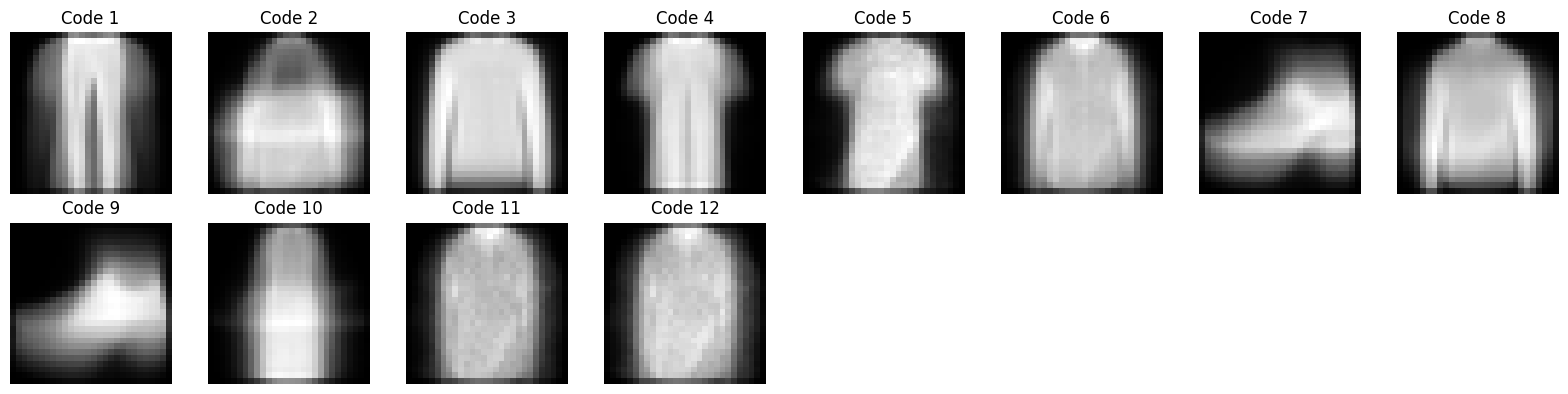

Epoch [141/500], Desc/Disc Loss: 1.1295, Decoder Loss: 0.0616
Epoch [142/500], Desc/Disc Loss: 1.4172, Decoder Loss: 0.0619
Epoch [143/500], Desc/Disc Loss: 1.3080, Decoder Loss: 0.0618
Epoch [144/500], Desc/Disc Loss: 1.3019, Decoder Loss: 0.0621
Epoch [145/500], Desc/Disc Loss: 1.4522, Decoder Loss: 0.0620
Epoch [146/500], Desc/Disc Loss: 1.2062, Decoder Loss: 0.0618
Epoch [147/500], Desc/Disc Loss: 1.3416, Decoder Loss: 0.0617
Epoch [148/500], Desc/Disc Loss: 1.4120, Decoder Loss: 0.0617
Epoch [149/500], Desc/Disc Loss: 1.3402, Decoder Loss: 0.0617
Epoch [150/500], Desc/Disc Loss: 1.1682, Decoder Loss: 0.0615
Analysing Trainable Codebook:
tensor([-0.0823,  0.0140, -0.0704, -0.0239, -0.0300, -0.0043, -0.0337, -0.0217,
         0.0582,  0.0710,  0.0230, -0.0255,  0.0290,  0.0295,  0.0517, -0.0498,
         0.0211, -0.0520,  0.0450, -0.0773, -0.0525,  0.0593,  0.0816,  0.0007,
        -0.0480, -0.0562, -0.0181, -0.0201, -0.0236, -0.0762,  0.0279,  0.0821,
         0.0040,  0.0113, -0.0

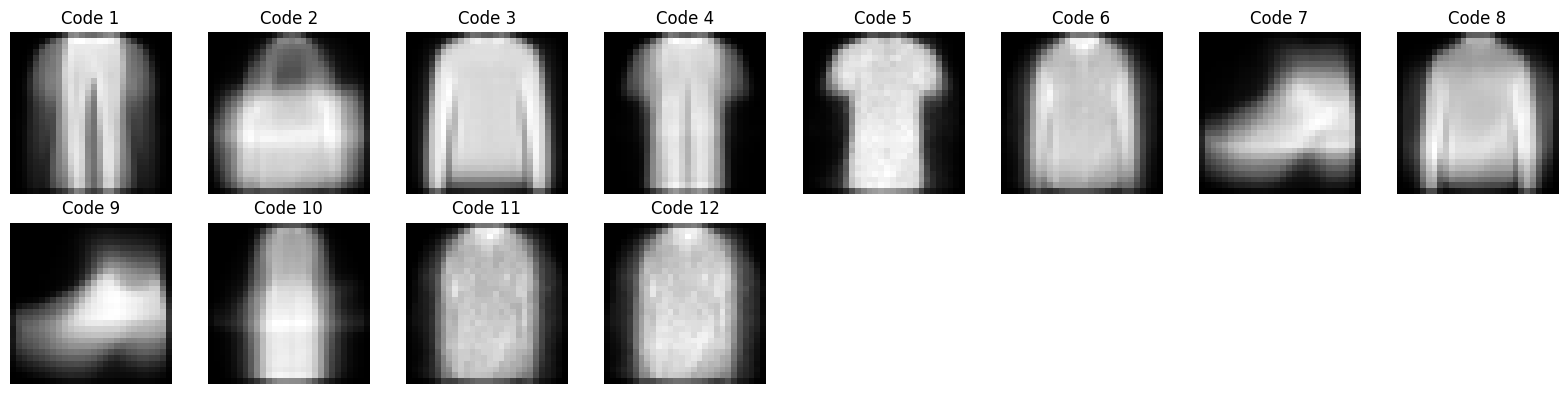


New codebook size: 13
Trainable: encoder.0.weight, Shape: torch.Size([256, 784])
Trainable: encoder.0.bias, Shape: torch.Size([256])
Trainable: encoder.2.weight, Shape: torch.Size([64, 256])
Trainable: encoder.2.bias, Shape: torch.Size([64])
Trainable: vq.trainable_embeddings, Shape: torch.Size([1, 64])


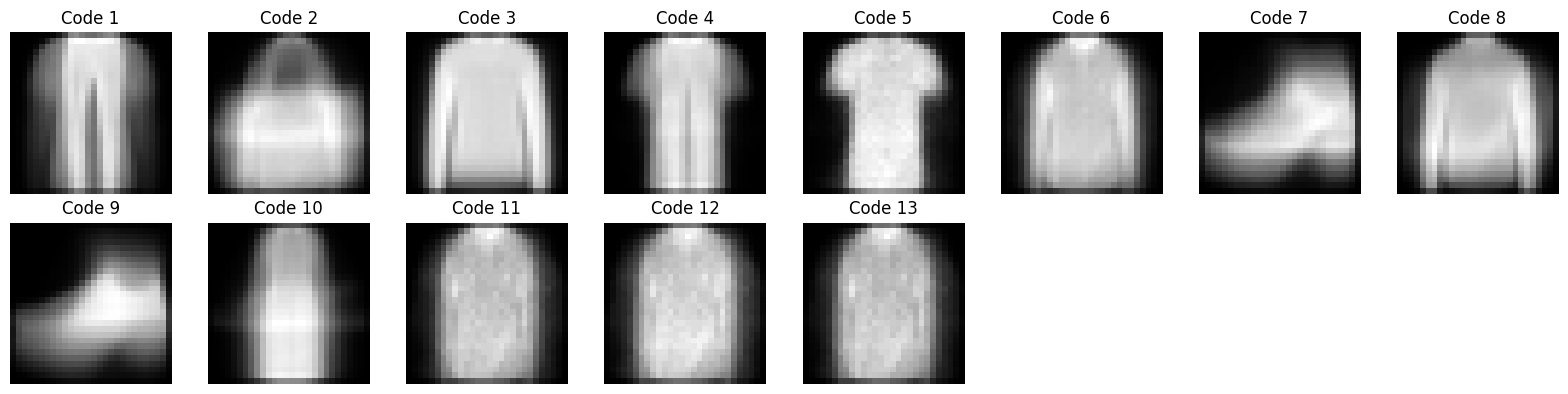

Epoch [151/500], Desc/Disc Loss: 1.1286, Decoder Loss: 0.0620


KeyboardInterrupt: 

In [ ]:
# Hyperparameters
input_dim = 784
hidden_dim = 256
embedding_dim = 64
num_embeddings = 10 #Initial Codebook Size

#Time to Grow
growth_rate = 50 #iterates every N epochs
growth_amount = 1 #Magnitude of increment of codebook when growth occurs

num_epochs = 500
batch_size = 256

# Choose a dataset (e.g., MNIST)
data, _ = datasets["Fashion-MNIST"]

# Initialize models
growing_descriptor_model = Growing_Descriptor(input_dim, hidden_dim, num_embeddings, embedding_dim)
discriminator_model = Discriminator(input_dim, embedding_dim, hidden_dim)
decoder_model = Decoder(embedding_dim, hidden_dim, input_dim)

# Optimizers
optimizer_desc = torch.optim.Adam(growing_descriptor_model.parameters(), lr=1e-4)
optimizer_disc = torch.optim.Adam(discriminator_model.parameters(), lr=1e-4)
optimizer_decoder = torch.optim.Adam(decoder_model.parameters(), lr=1e-4)

# Loss functions
criterion = nn.BCELoss()
mse_loss = nn.MSELoss()

#plot_codes_as_image(growing_descriptor_model.get_codebook())

print_trainable_codebook(growing_descriptor_model)
visualize_codebook_decodings(growing_descriptor_model, decoder_model, image_shape=(28, 28))


# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size]
        indices = torch.randperm(len(batch_data))
        shuffled_data = batch_data[indices]

        # Train growing descriptor and discriminator
        optimizer_desc.zero_grad()
        optimizer_disc.zero_grad()

        z, quantized, vq_loss, _ = growing_descriptor_model(batch_data)

        disc_output_real = discriminator_model(vq_input=quantized, image_input=batch_data)
        disc_output_fake = discriminator_model(vq_input=quantized, image_input=shuffled_data)

        real_loss = criterion(disc_output_real, torch.ones_like(disc_output_real))
        fake_loss = criterion(disc_output_fake, torch.zeros_like(disc_output_fake))

        desc_disc_loss = real_loss + fake_loss + vq_loss
        desc_disc_loss.backward(retain_graph=True)

        optimizer_desc.step()
        optimizer_disc.step()

        # Train decoder separately
        optimizer_decoder.zero_grad()

        # Separately train decoder
        reconstructed = decoder_model(quantized.detach())
        decoder_loss = mse_loss(reconstructed, batch_data)

        decoder_loss.backward()

        optimizer_decoder.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Desc/Disc Loss: {desc_disc_loss.item():.4f}, Decoder Loss: {decoder_loss.item():.4f}")

    if (epoch + 1) % 10 == 0:
        print_trainable_codebook(growing_descriptor_model)
        visualize_codebook_decodings(growing_descriptor_model, decoder_model, image_shape=(28, 28))

    # Grow the codebook at end of every N Epochs
    if epoch % growth_rate == growth_rate - 1:
        growing_descriptor_model.grow_codebook(num_new_vectors=growth_amount)
        print(f"\nNew codebook size: {len(growing_descriptor_model.get_codebook())}")


        # Verify trainable parameters
        for name, param in growing_descriptor_model.named_parameters():
            if param.requires_grad:
                print(f"Trainable: {name}, Shape: {param.shape}")

        visualize_codebook_decodings(growing_descriptor_model, decoder_model, image_shape=(28, 28))

Exact Pairs:


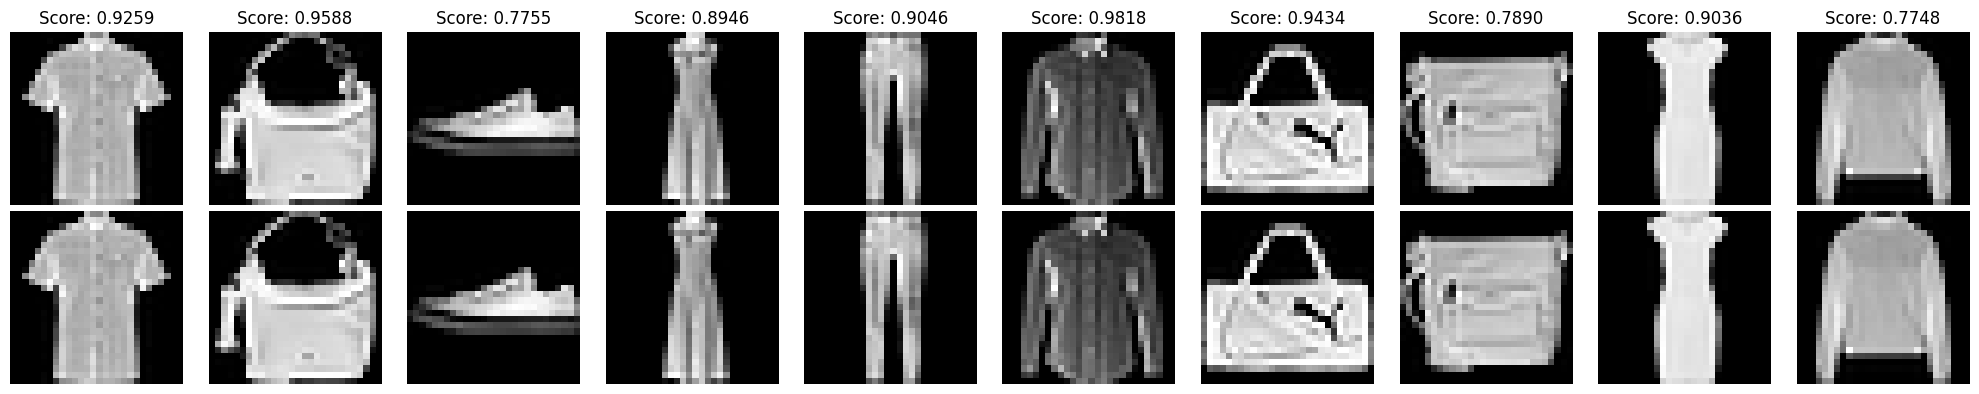


Mixed Pairs:


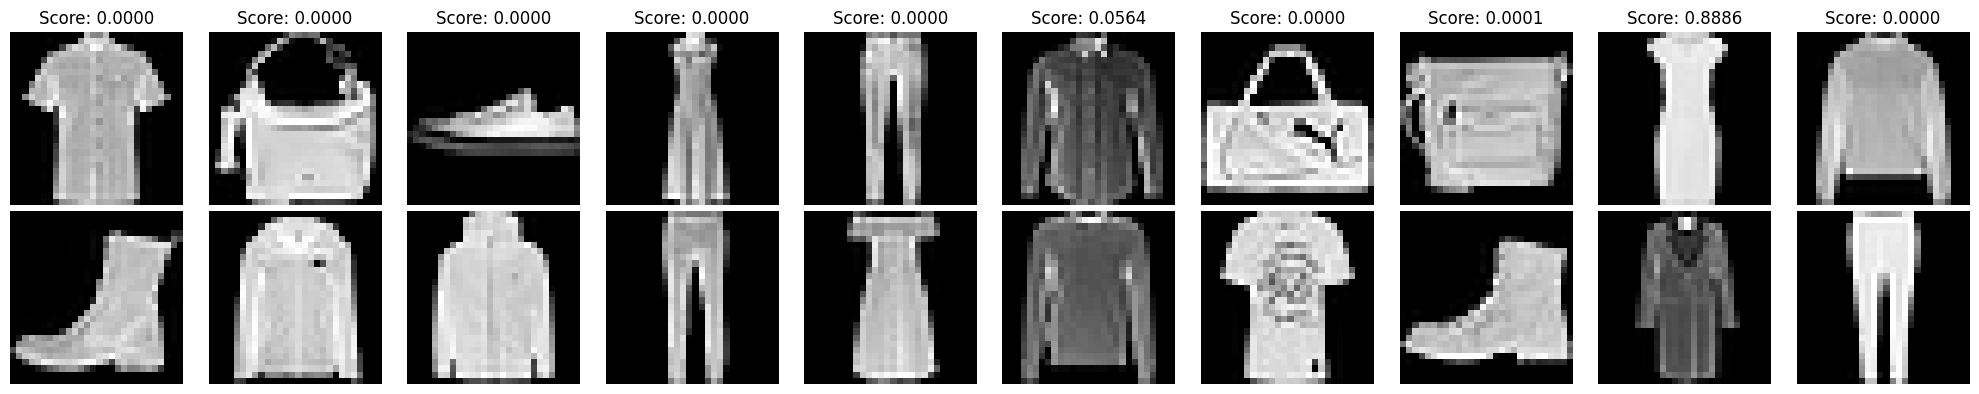

In [ ]:
# Choose a dataset (e.g., MNIST, Fashion-MNIST)
data, _ = datasets["Fashion-MNIST"]

idx, idx2  = np.random.randint(len(data)), np.random.randint(len(data))

#Pick 10 Test Images from Data
test_images = data[idx:idx+10]

#Pick 10 More different test images
test_images_2 = data[idx2:idx2+10]

#Stack images into exact and mixed (inexact) pairs
stacked_exact_pairs = torch.stack((test_images, test_images), dim=0)
stacked_mixed_pairs = torch.stack((test_images, test_images_2), dim=0)

#Test images described by communicator
z, quantized, _, _ = growing_descriptor_model(test_images)

#Quantized rep communicated and compared against original described images, and different images
exact_pair_scores = discriminator_model(quantized, test_images)
mixed_pair_scores = discriminator_model(quantized, test_images_2)

#Image pairs are displayed. Pairs (vertical) are labelled with the disriminator similarity score

print("Exact Pairs:")
visualize_tensor_grid(stacked_exact_pairs, exact_pair_scores)

print("\nMixed Pairs:")
visualize_tensor_grid(stacked_mixed_pairs, mixed_pair_scores)